# EDA for the Heart Failure Kaggle Dataset

This notebook runs several EDA analyses on the heart failure kaggle dataset (link)

# Imports

In [1]:
import os
import sys
import datetime as dt
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from pandas.api.types import is_float_dtype
# from matplotlib import gridspec
# import yaml
import re
import seaborn as sns
# import json

%matplotlib inline


# Data Wrangling

In [2]:
def plot_histogram(df, col_name, bins=20):

    plt.figure(figsize=(8, 6))
    sns.histplot(df[col_name], kde=True, bins=bins)

    mean_val = np.mean(df[col_name])
    median_val = np.median(df[col_name])

    plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=2, label=f'Mean {col_name}: {mean_val:.2f}')
    plt.axvline(median_val, color='green', linestyle='dashed', linewidth=2, label=f'Median {col_name}: {median_val}')

    plt.title(f'Distribution of {col_name}')
    plt.xlabel(col_name)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


In [3]:
df = pd.read_csv("../data/heart.csv")
dummy_df = pd.get_dummies(df, columns=['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], drop_first=True)

df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 39, 59, float('inf')], labels=['Less than 40', '40-60', '60 and above'])

num_cols = ['RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

first_age_df = df[df.AgeGroup == 'Less than 40']
second_age_df = df[df.AgeGroup == '40-60']
third_age_df = df[df.AgeGroup == '60 and above']

# poor_df = df[df.CardiovascularHealth == 'poor']
# mid_df = df[df.CardiovascularHealth == 'mid']
# healthy_df = df[df.CardiovascularHealth == 'healthy']



In [4]:
# Domain knowledge (old peak should be higher), ask cardiolgist 
# weights = {'RestingBP': 0.3, 'Cholesterol': 0.3, 'MaxHR': 0.1, 'Oldpeak': 0.3} # 87% of healthy with heart disease
# weights = {'RestingBP': 0.35, 'Cholesterol': 0.2, 'MaxHR': 0.05, 'Oldpeak': 0.4} # 88% of healthy with heart disease
weights = {'RestingBP': 0.3, 'Cholesterol': 0.3, 'MaxHR': 0.2, 'Oldpeak': 0.2} # 87% of healthy with heart disease
# weights = {'RestingBP': 0.4, 'Cholesterol': 0.4, 'MaxHR': 0.1, 'Oldpeak': 0.1} # 88% of healthy with heart disease


# Calculate a composite score for cardiovascular age
df['CardiovascularScore'] = df[num_cols].mul(weights.values()).sum(axis=1)

# Normalize the scores to be in the range [0, 100]
df['CardiovascularScore'] = 100 - ((df['CardiovascularScore'] - df['CardiovascularScore'].min()) / (df['CardiovascularScore'].max() - df['CardiovascularScore'].min()) * 100)

bins = [0, 33.33, 66.66, 100]
labels = ['poor', 'mid', 'healthy']

df['CardiovascularHealth'] = pd.cut(df['CardiovascularScore'], bins=bins, labels=labels, include_lowest=True)


# # Compute percentiles dynamically
# percentiles = df['CardiovascularScore'].quantile([0.333, 0.666, 1.0]).values

# # Assign new categories based on percentile thresholds
# df['CardiovascularHealth'] = pd.cut(
#     df['CardiovascularScore'],
#     bins=[df['CardiovascularScore'].min(), percentiles[0], percentiles[1], df['CardiovascularScore'].max()],
#     labels=['poor', 'mid', 'healthy'],
#     include_lowest=True
# )

poor_df = df[df.CardiovascularHealth == 'poor']
mid_df = df[df.CardiovascularHealth == 'mid']
healthy_df = df[df.CardiovascularHealth == 'healthy']

In [5]:

# Count and percentage of patients in each cardiovascular health category
cardio_health_counts = df['CardiovascularHealth'].value_counts().sort_index()
cardio_health_percentages = (cardio_health_counts / len(df) * 100).round(0)  # Round to whole numbers

# Heart disease prevalence by cardiovascular health category
heart_disease_by_cardio_health = df.groupby('CardiovascularHealth', observed=True)['HeartDisease'].value_counts(normalize=True).unstack() * 100
heart_disease_by_cardio_health = heart_disease_by_cardio_health.round(0)  # Ensure rounding is applied

# Create a structured DataFrame with totals
cardio_health_summary = pd.DataFrame({
    'Number of Patients': cardio_health_counts.astype(str) + " (" + cardio_health_percentages.astype(int).astype(str) + "%)",
    'Heart Disease': cardio_health_counts.mul(heart_disease_by_cardio_health[1].fillna(0) / 100).round(0).astype(int).astype(str) + " (" + heart_disease_by_cardio_health[1].fillna(0).round(0).astype(int).astype(str) + "%)",
    'No Heart Disease': cardio_health_counts.mul(heart_disease_by_cardio_health[0].fillna(0) / 100).round(0).astype(int).astype(str) + " (" + heart_disease_by_cardio_health[0].fillna(0).round(0).astype(int).astype(str) + "%)"
}).reset_index().rename(columns={'CardiovascularHealth': 'Cardiovascular Health Category'})

# Add a total row
total_patients = len(df)
total_heart_disease = df['HeartDisease'].sum()
total_no_heart_disease = total_patients - total_heart_disease

cardio_health_summary.loc[len(cardio_health_summary)] = [
    "Total",
    f"{total_patients} (100%)",
    f"{total_heart_disease} (100%)",
    f"{total_no_heart_disease} (100%)"
]

cardio_health_summary

,Cardiovascular Health Category,Number of Patients,Heart Disease,No Heart Disease
0,poor,37 (4%),19 (51%),18 (49%)
1,mid,700 (76%),329 (47%),371 (53%)
2,healthy,181 (20%),157 (87%),24 (13%)
3,Total,918 (100%),508 (100%),410 (100%)


In [6]:
total_patients = len(df)
heart_disease_counts = df['HeartDisease'].value_counts()
sex_counts = df['Sex'].value_counts()

heart_disease_distribution = (heart_disease_counts / total_patients * 100).round()
sex_distribution = (sex_counts / total_patients * 100).round()

heart_disease_by_sex_counts = df.groupby('Sex')['HeartDisease'].value_counts().unstack()
heart_disease_by_sex_percent = (df.groupby('Sex')['HeartDisease'].value_counts(normalize=True) * 100).unstack().round()

print(f"Total patients: {total_patients}\n")

print("Heart Disease Distribution:")
for status, count in heart_disease_counts.items():
    print(f" - {'Heart Disease' if status == 1 else 'No Heart Disease'}: {count} ({heart_disease_distribution[status]}%)")
print()

print("Sex Distribution:")
for sex, count in sex_counts.items():
    print(f" - {sex}: {count} ({sex_distribution[sex]}%)")
print()

print("Heart Disease by Sex:")
for sex in heart_disease_by_sex_counts.index:
    print(f" - {sex}:")
    print(f"   - No Heart Disease: {heart_disease_by_sex_counts.loc[sex, 0]} ({heart_disease_by_sex_percent.loc[sex, 0]}%)")
    print(f"   - Heart Disease: {heart_disease_by_sex_counts.loc[sex, 1]} ({heart_disease_by_sex_percent.loc[sex, 1]}%)")


Total patients: 918

Heart Disease Distribution:
 - Heart Disease: 508 (55.0%)
 - No Heart Disease: 410 (45.0%)

Sex Distribution:
 - M: 725 (79.0%)
 - F: 193 (21.0%)

Heart Disease by Sex:
 - F:
   - No Heart Disease: 143 (74.0%)
   - Heart Disease: 50 (26.0%)
 - M:
   - No Heart Disease: 267 (37.0%)
   - Heart Disease: 458 (63.0%)


In [7]:
age_summary = df['Age'].describe()

print("\n===== Age Summary Statistics =====")
print(age_summary.to_string())


===== Age Summary Statistics =====
count    918.000000
mean      53.510893
std        9.432617
min       28.000000
25%       47.000000
50%       54.000000
75%       60.000000
max       77.000000


In [8]:
# Count and percentage of patients in each age group
age_group_counts = df['AgeGroup'].value_counts().sort_index()
age_group_percentages = (age_group_counts / len(df) * 100).round(1)

# Heart disease prevalence by age group
# heart_disease_by_age_group = df.groupby('AgeGroup')['HeartDisease'].value_counts(normalize=True).unstack() * 100
heart_disease_by_age_group = df.groupby('AgeGroup', observed=True)['HeartDisease'].value_counts(normalize=True).unstack() * 100

# Create a structured DataFrame with totals
age_group_summary = pd.DataFrame({
    'Number of Patients': age_group_counts.astype(str) + " (" + age_group_percentages.astype(str) + "%)",
    'Heart Disease': age_group_counts.mul(heart_disease_by_age_group[1].fillna(0) / 100).round(0).astype(int).astype(str) + 
                     " (" + heart_disease_by_age_group[1].fillna(0).round(1).astype(str) + "%)",
    'No Heart Disease': age_group_counts.mul(heart_disease_by_age_group[0].fillna(0) / 100).round(0).astype(int).astype(str) + 
                        " (" + heart_disease_by_age_group[0].fillna(0).round(1).astype(str) + "%)"
}).reset_index().rename(columns={'AgeGroup': 'Age Group'})

# Add a total row
total_patients = len(df)
total_heart_disease = df['HeartDisease'].sum()
total_no_heart_disease = total_patients - total_heart_disease

age_group_summary.loc[len(age_group_summary)] = [
    "Total",
    f"{total_patients} (100%)",
    f"{total_heart_disease} (100%)",
    f"{total_no_heart_disease} (100%)"
]

age_group_summary

,Age Group,Number of Patients,Heart Disease,No Heart Disease
0,Less than 40,80 (8.7%),26 (32.5%),54 (67.5%)
1,40-60,585 (63.7%),297 (50.8%),288 (49.2%)
2,60 and above,253 (27.6%),185 (73.1%),68 (26.9%)
3,Total,918 (100%),508 (100%),410 (100%)


In [9]:
# Oldpeak depicts ST depression induced by exercise relative to rest on electrocardiogram, so 
# i'd expect some sort of correlation between oldpeak (which in essense can depict severity of chest pain) and chest pain

dummy_df[['ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'Oldpeak']].corr()


,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,Oldpeak
ChestPainType_ATA,1.000000,-0.256767,-0.110679,-0.262124
ChestPainType_NAP,-0.256767,1.000000,-0.122381,-0.106212
ChestPainType_TA,-0.110679,-0.122381,1.000000,0.032231
Oldpeak,-0.262124,-0.106212,0.032231,1.000000


In [10]:
healthy_df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,AgeGroup,CardiovascularScore,CardiovascularHealth
78,52,M,ATA,140,100,0,Normal,138,Y,0.0,Up,0,40-60,68.054256,healthy
98,56,M,ASY,120,85,0,Normal,140,N,0.0,Up,0,40-60,72.778297,healthy
151,48,M,ATA,100,159,0,Normal,100,N,0.0,Up,0,40-60,68.942937,healthy
227,38,M,ASY,92,117,0,Normal,134,Y,2.5,Flat,1,Less than 40,72.544434,healthy
263,59,M,ASY,130,126,0,Normal,125,N,0.0,Flat,1,40-60,67.025257,healthy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1,40-60,84.892423,healthy
536,62,M,NAP,133,0,1,ST,119,Y,1.2,Flat,1,60 and above,84.733396,healthy
541,76,M,NAP,104,113,0,LVH,120,N,3.5,Down,1,60 and above,72.637979,healthy
571,69,M,ASY,140,110,1,Normal,109,Y,1.5,Flat,1,60 and above,69.223573,healthy


In [11]:
df[['Age', 'AgeGroup', 'CardiovascularScore', 'CardiovascularHealth', 'Sex', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'HeartDisease']]

,Age,AgeGroup,CardiovascularScore,CardiovascularHealth,Sex,RestingBP,Cholesterol,MaxHR,Oldpeak,HeartDisease
0,40,40-60,38.353601,mid,M,140,289,172,0.0,0
1,49,40-60,52.245089,mid,F,160,180,156,1.0,1
2,37,Less than 40,47.521048,mid,M,130,283,98,0.0,0
3,48,40-60,55.004677,mid,F,138,214,108,1.5,1
4,54,40-60,54.817587,mid,M,150,195,122,0.0,0
...,...,...,...,...,...,...,...,...,...,...
913,45,40-60,49.700655,mid,M,110,264,132,1.2,1
914,68,60 and above,53.844715,mid,M,144,193,141,3.4,1
915,57,40-60,67.146866,healthy,M,130,131,115,1.2,1
916,57,40-60,47.006548,mid,F,130,236,174,0.0,1


In [12]:
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,AgeGroup,CardiovascularScore,CardiovascularHealth
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0,40-60,38.353601,mid
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1,40-60,52.245089,mid
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0,Less than 40,47.521048,mid
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1,40-60,55.004677,mid
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0,40-60,54.817587,mid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1,40-60,49.700655,mid
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1,60 and above,53.844715,mid
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1,40-60,67.146866,healthy
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1,40-60,47.006548,mid


In [13]:
# first_age_df.CardiovascularHealth.value_counts()

In [14]:
# second_age_df.CardiovascularHealth.value_counts()

In [15]:
# third_age_df.CardiovascularHealth.value_counts()

In [16]:
df[['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']].corr()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
Age,1.000000,0.254399,-0.095282,-0.382045,0.258612
RestingBP,0.254399,1.000000,0.100893,-0.112135,0.164803
Cholesterol,-0.095282,0.100893,1.000000,0.235792,0.050148
MaxHR,-0.382045,-0.112135,0.235792,1.000000,-0.160691
Oldpeak,0.258612,0.164803,0.050148,-0.160691,1.000000


In [17]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,CardiovascularScore
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377,55.286169
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414,16.494545
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000,45.168382
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000,51.749298
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000,59.600094
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000,100.000000


In [18]:
# first_age_df[['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']].corr()

In [19]:
# first_age_df.describe()

In [20]:
# second_age_df[['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']].corr()

In [21]:
# second_age_df.describe()

In [22]:
# third_age_df[['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']].corr()

In [23]:
# third_age_df.describe()

In [24]:
# for df in [first_age_df, second_age_df, third_age_df]:
#     plt.figure(figsize=(8, 6))
#     sns.kdeplot(df, x='RestingBP', hue='HeartDisease', palette='viridis', fill=True)
#     plt.title(f'Distribution of RestingBP by Heart Disease')
#     plt.show()

In [25]:
healthy_df.AgeGroup.value_counts()

AgeGroup
40-60           97
60 and above    73
Less than 40    11
Name: count, dtype: int64

# CardiovascularScore

## RestingBP

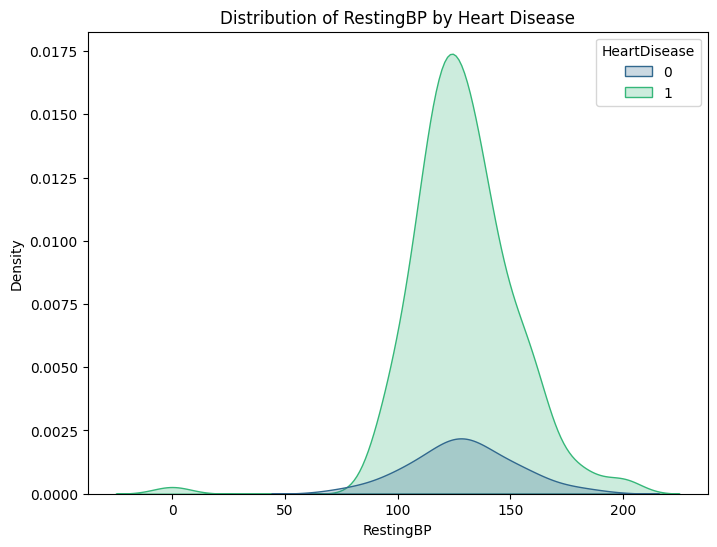

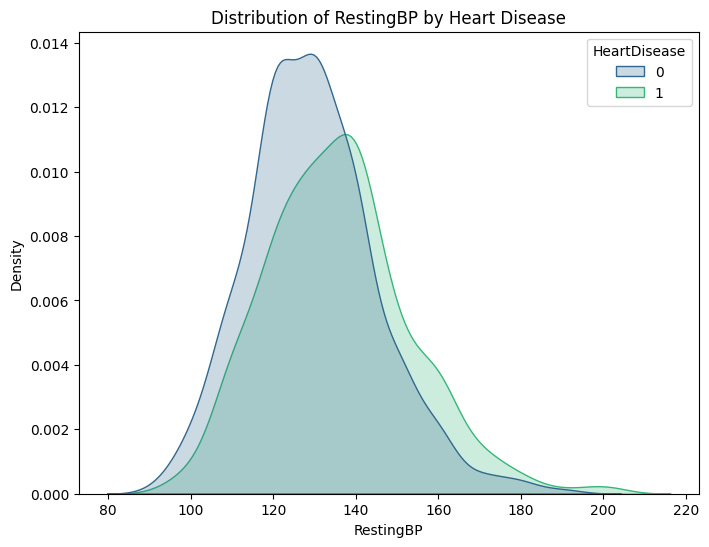

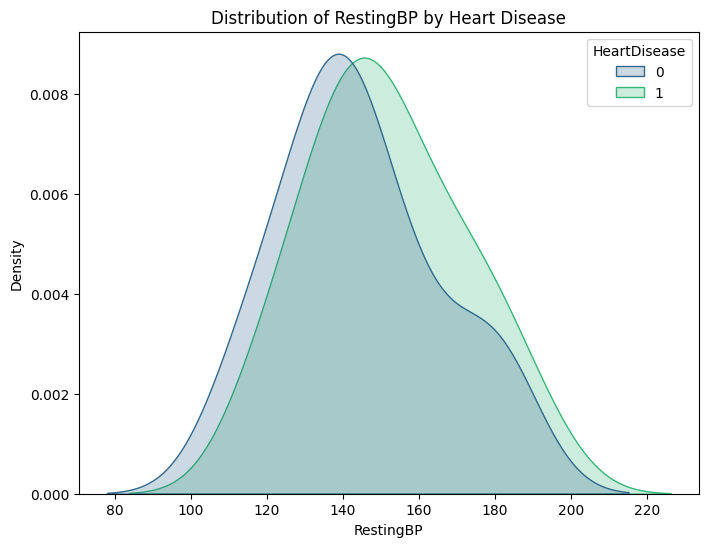

In [26]:
for df in [healthy_df, mid_df, poor_df]:
    plt.figure(figsize=(8, 6))
    sns.kdeplot(df, x='RestingBP', hue='HeartDisease', palette='viridis', fill=True)
    plt.title(f'Distribution of RestingBP by Heart Disease')
    plt.show()

## Cholesterol

In [27]:
# for df in [first_age_df, second_age_df, third_age_df]:
#     plt.figure(figsize=(8, 6))
#     sns.kdeplot(df, x='Cholesterol', hue='HeartDisease', palette='viridis', fill=True)
#     plt.title(f'Distribution of Cholesterol by Heart Disease')
#     plt.show()

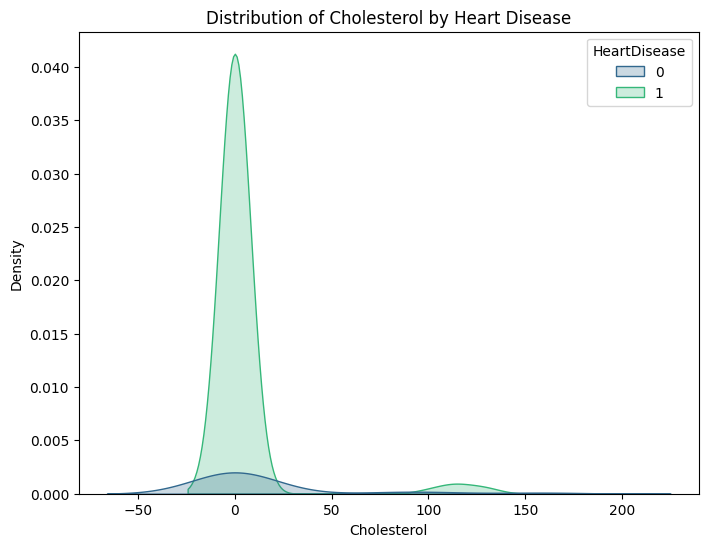

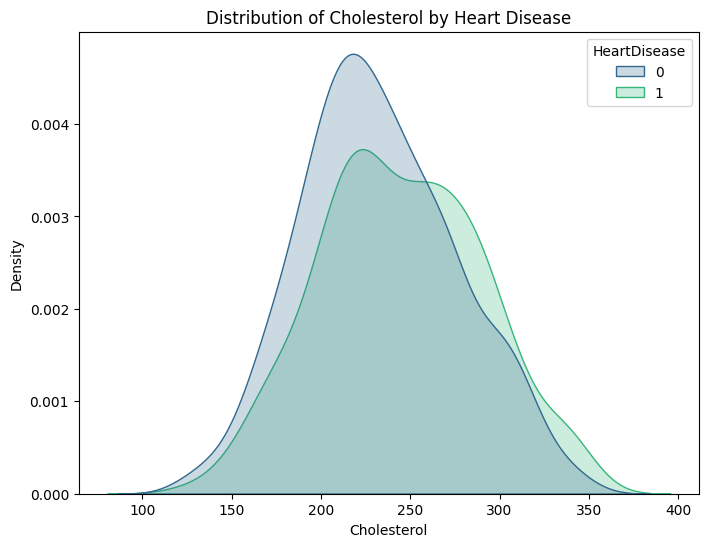

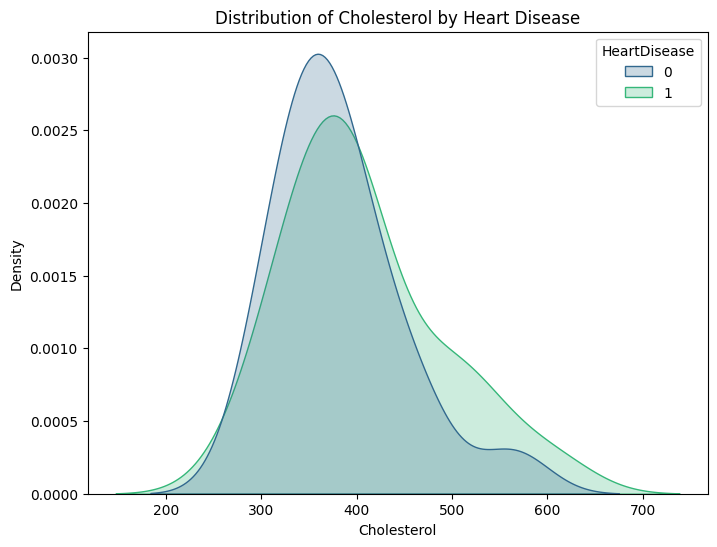

In [28]:
for df in [healthy_df, mid_df, poor_df]:
    plt.figure(figsize=(8, 6))
    sns.kdeplot(df, x='Cholesterol', hue='HeartDisease', palette='viridis', fill=True)
    plt.title(f'Distribution of Cholesterol by Heart Disease')
    plt.show()

## Oldpeak

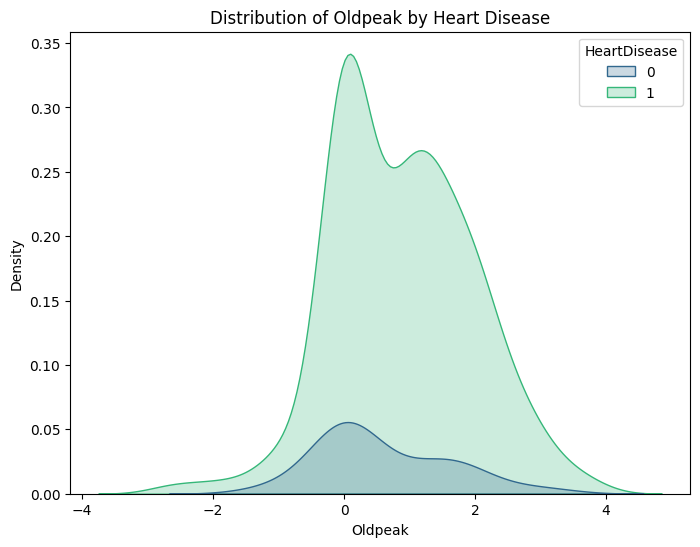

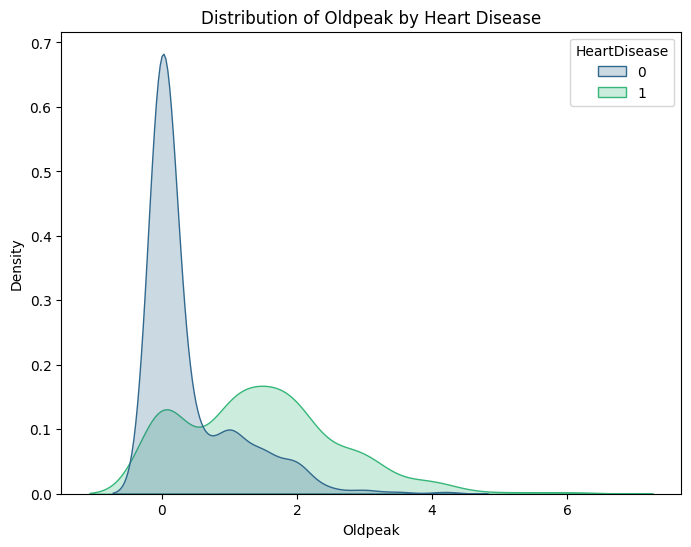

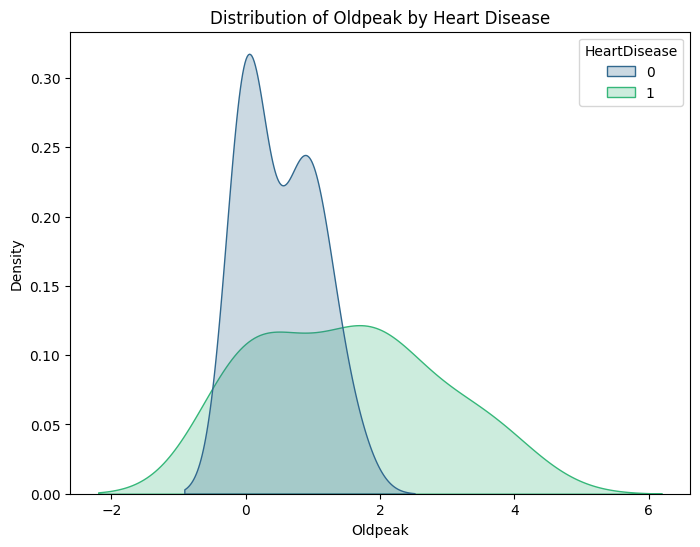

In [29]:
for df in [healthy_df, mid_df, poor_df]:
    plt.figure(figsize=(8, 6))
    sns.kdeplot(df, x='Oldpeak', hue='HeartDisease', palette='viridis', fill=True)
    plt.title(f'Distribution of Oldpeak by Heart Disease')
    plt.show()

## MaxHR

In [30]:
# for df in [first_age_df, second_age_df, third_age_df]:
#     plt.figure(figsize=(8, 6))
#     sns.kdeplot(df, x='MaxHR', hue='HeartDisease', palette='viridis', fill=True)
#     plt.title(f'Distribution of MaxHR by Heart Disease')
#     plt.show()

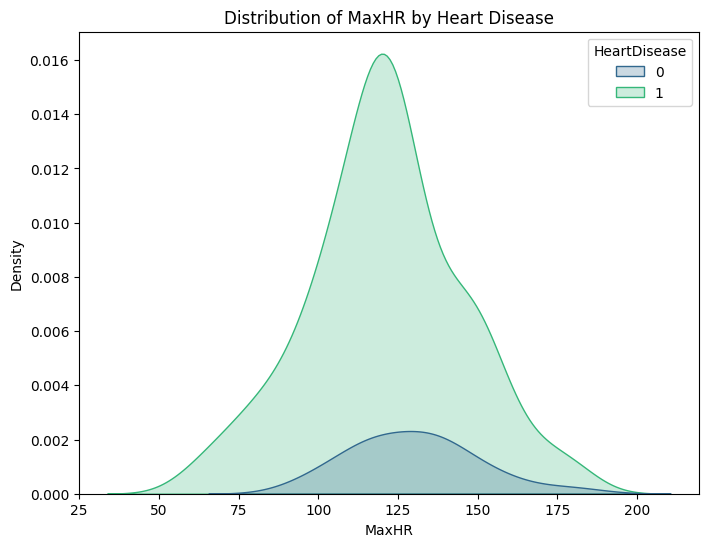

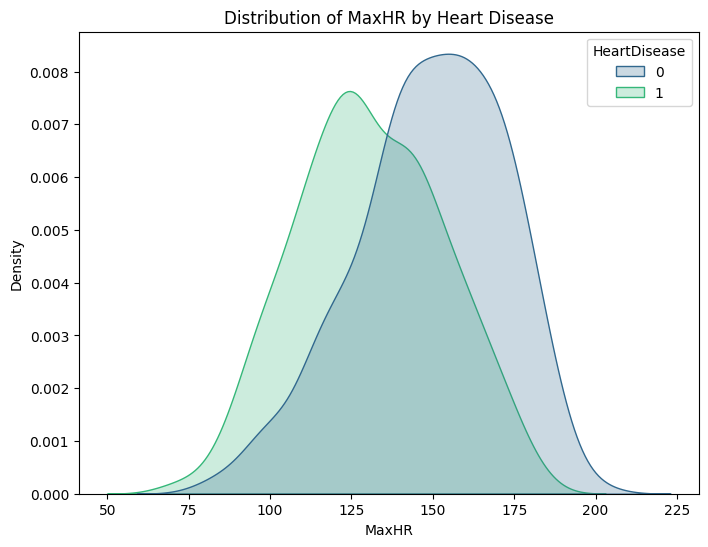

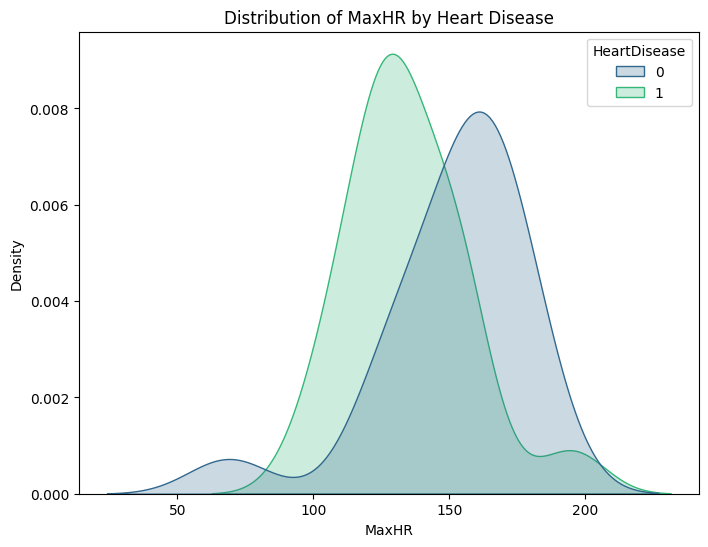

In [31]:
for df in [healthy_df, mid_df, poor_df]:
    plt.figure(figsize=(8, 6))
    sns.kdeplot(df, x='MaxHR', hue='HeartDisease', palette='viridis', fill=True)
    plt.title(f'Distribution of MaxHR by Heart Disease')
    plt.show()

# Age Groups

In [32]:
# for df in [first_age_df, second_age_df, third_age_df]:
#     plt.figure(figsize=(8, 6))
#     sns.kdeplot(df, x='Oldpeak', hue='HeartDisease', palette='viridis', fill=True)
#     plt.title(f'Distribution of Oldpeak by Heart Disease')
#     plt.show()

In [33]:
# num_cols = ['RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
# for col in num_cols:
#     plt.figure(figsize=(8, 6))
#     sns.kdeplot(first_age_df, x=col, hue='HeartDisease', palette='viridis', fill=True)
#     plt.title(f'Distribution of {col} by Heart Disease \n Patients Less than 40')
#     plt.show()


In [34]:
# num_cols = ['RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
# for col in num_cols:
#     plt.figure(figsize=(8, 6))
#     sns.kdeplot(second_age_df, x=col, hue='HeartDisease', palette='viridis', fill=True)
#     plt.title(f'Distribution of {col} by Heart Disease \n Patients between 40 and 60')
#     plt.show()

In [35]:
# num_cols = ['RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
# for col in num_cols:
#     plt.figure(figsize=(8, 6))
#     sns.kdeplot(third_age_df, x=col, hue='HeartDisease', palette='viridis', fill=True)
#     plt.title(f'Distribution of {col} by Heart Disease \n Patients 60 and Above')
#     plt.show()

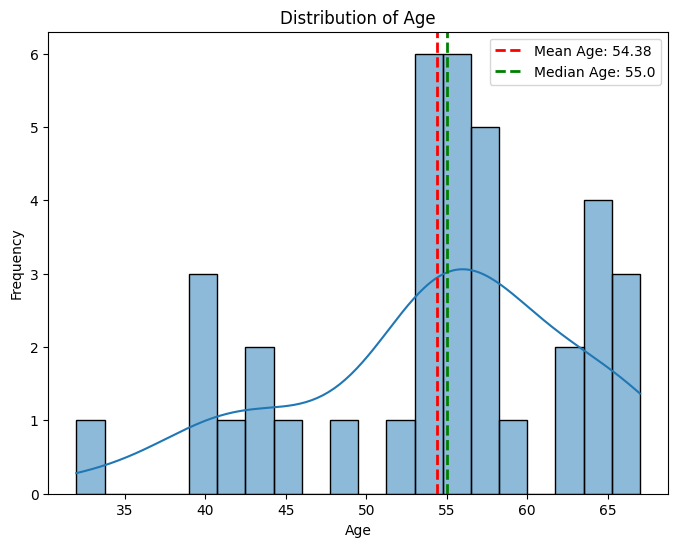

In [36]:
plot_histogram(df, 'Age')

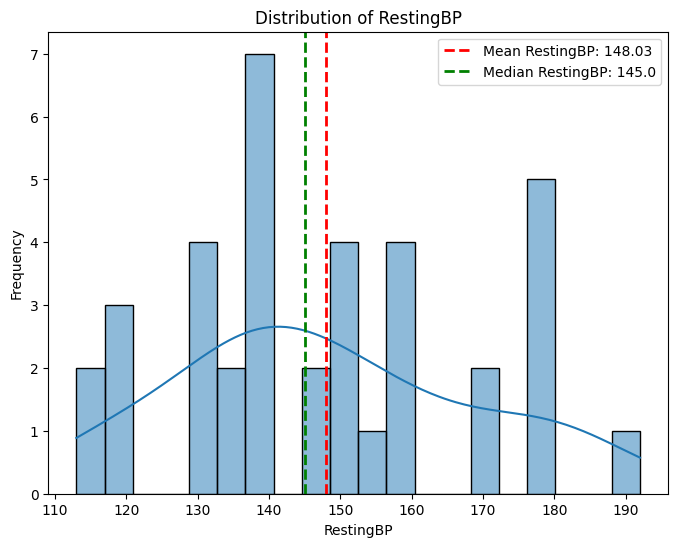

In [37]:
plot_histogram(df, 'RestingBP')

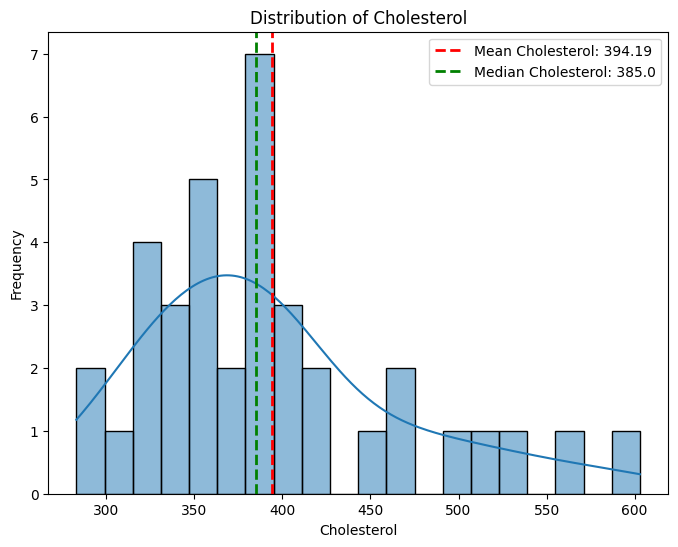

In [38]:
plot_histogram(df, 'Cholesterol')

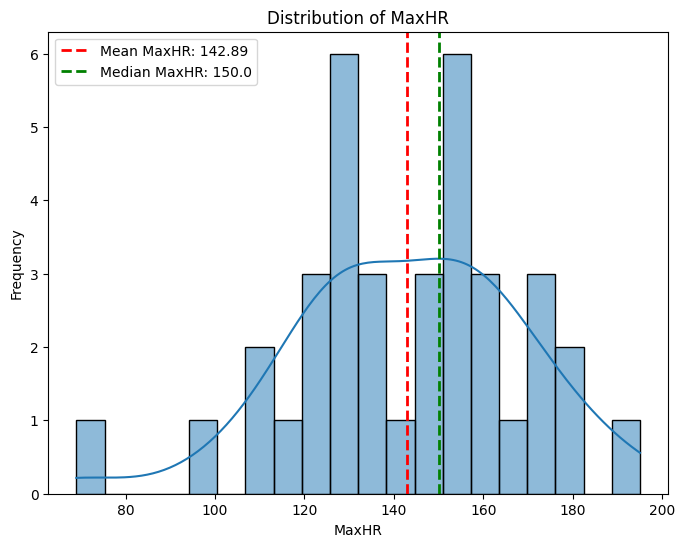

In [39]:
plot_histogram(df, 'MaxHR')

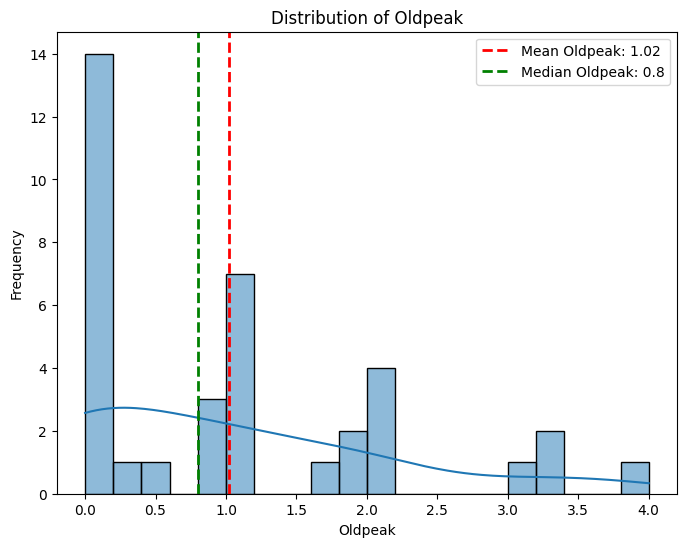

In [40]:
plot_histogram(df, 'Oldpeak')

In [41]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# # Assuming df is your DataFrame

# # Convert categorical columns to categorical type
# df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 40, 60, float('inf')], labels=['Less than 40', '40-60', '60 and above'])
# df['ChestPainType'] = df['ChestPainType'].astype('category')
# df['RestingECG'] = df['RestingECG'].astype('category')
# df['ST_Slope'] = df['ST_Slope'].astype('category')

# # Define the numeric columns
# num_cols = ['RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

# # Create a FacetGrid for separate plots
# g = sns.FacetGrid(pd.melt(df, id_vars=['AgeGroup', 'HeartDisease'], value_vars=num_cols),
#                   col='variable', row='AgeGroup', hue='HeartDisease', height=4, palette='viridis', margin_titles=True)

# # Map kdeplot to each subplot
# g.map_dataframe(sns.kdeplot, x='value', common_norm=False, fill=True)
# g.set_axis_labels('', 'Density')

# # Add legend
# g.add_legend(title='Heart Disease', bbox_to_anchor=(1, 1))

# # Set titles
# for (row_val, col_val) in g.axes_dict.keys():
#     if row_val == 'RestingBP':
#         g.axes_dict[(row_val, col_val)].set_xlabel(f'{col_val} Density')

# # Adjust the overall plot title
# plt.suptitle('Distribution of Numeric Features by Heart Disease (Grouped by Age)', y=1.02)
# plt.show()


In [42]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# # Assuming df is your DataFrame

# # Convert categorical columns to categorical type
# df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 40, 60, float('inf')], labels=['Less than 40', '40-60', '60 and above'])
# df['ChestPainType'] = df['ChestPainType'].astype('category')
# df['RestingECG'] = df['RestingECG'].astype('category')
# df['ST_Slope'] = df['ST_Slope'].astype('category')

# # Define the numeric columns
# num_cols = ['RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

# # Create a FacetGrid for separate plots
# g = sns.FacetGrid(pd.melt(df, id_vars=['AgeGroup', 'HeartDisease'], value_vars=num_cols),
#                   col='variable', row='AgeGroup', hue='HeartDisease', height=5, aspect=1.2, palette='viridis', margin_titles=True)

# # Map histogram to each subplot
# g.map_dataframe(sns.histplot, x='value', bins=20, kde=True, common_norm=False, fill=True)
# g.set_axis_labels('', 'Density')

# # Add legend
# g.add_legend(title='Heart Disease', bbox_to_anchor=(1, 1))

# # Set titles
# for (row_val, col_val) in g.axes_dict.keys():
#     if row_val == 'RestingBP':
#         g.axes_dict[(row_val, col_val)].set_xlabel(f'{col_val} Density')

# # Adjust the overall plot title
# plt.suptitle('Distribution of Numeric Features by Heart Disease (Grouped by Age)', y=1.02)
# plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to prevent clipping of titles
# plt.show()


In [43]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# # Assuming df is your DataFrame

# # Convert categorical columns to categorical type
# df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 40, 60, float('inf')], labels=['Less than 40', '40-60', '60 and above'])
# df['ChestPainType'] = df['ChestPainType'].astype('category')
# df['RestingECG'] = df['RestingECG'].astype('category')
# df['ST_Slope'] = df['ST_Slope'].astype('category')

# # Define the numeric columns
# num_cols = ['RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

# # Create a FacetGrid for separate plots
# g = sns.FacetGrid(df, col='AgeGroup', row='ST_Slope', hue='HeartDisease', height=4, palette='viridis', margin_titles=True)

# # Map kdeplot to each subplot
# g.map_dataframe(sns.kdeplot, x='MaxHR', common_norm=False, fill=True)
# g.set_axis_labels('', 'Density')

# # Add legend
# g.add_legend(title='Heart Disease', bbox_to_anchor=(1, 1))

# # Set titles
# for (row_val, col_val) in g.axes_dict.keys():
#     if col_val == 0:
#         g.axes_dict[(row_val, col_val)].set_ylabel(f'{row_val} Density')

# # Adjust the overall plot title
# plt.suptitle('Distribution of MaxHR by Heart Disease (Grouped by Age and ST_Slope)', y=1.02)
# plt.show()


In [44]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# # Assuming df is your DataFrame

# # Define the numeric columns and the number of bins for age
# num_cols = ['RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
# num_bins = 3  # You can adjust the number of bins as needed

# # Create age bins
# df['AgeGroup'] = pd.cut(df['Age'], bins=num_bins, labels=[f'Age Group {i+1}' for i in range(num_bins)])

# # Create a FacetGrid for separate plots
# g = sns.FacetGrid(df, col='AgeGroup', col_wrap=3, height=5)
# g.map_dataframe(sns.kdeplot, x='RestingBP', hue='HeartDisease', fill=True, palette='viridis', common_norm=False)
# g.set_axis_labels('RestingBP', 'Density')
# g.set_titles('Age Group {col_name}')

# # Adjust the overall plot title
# plt.suptitle('Distribution of RestingBP by Heart Disease (Grouped by Age)', y=1.02)
# plt.show()


# Numerical Features by HeartDisease

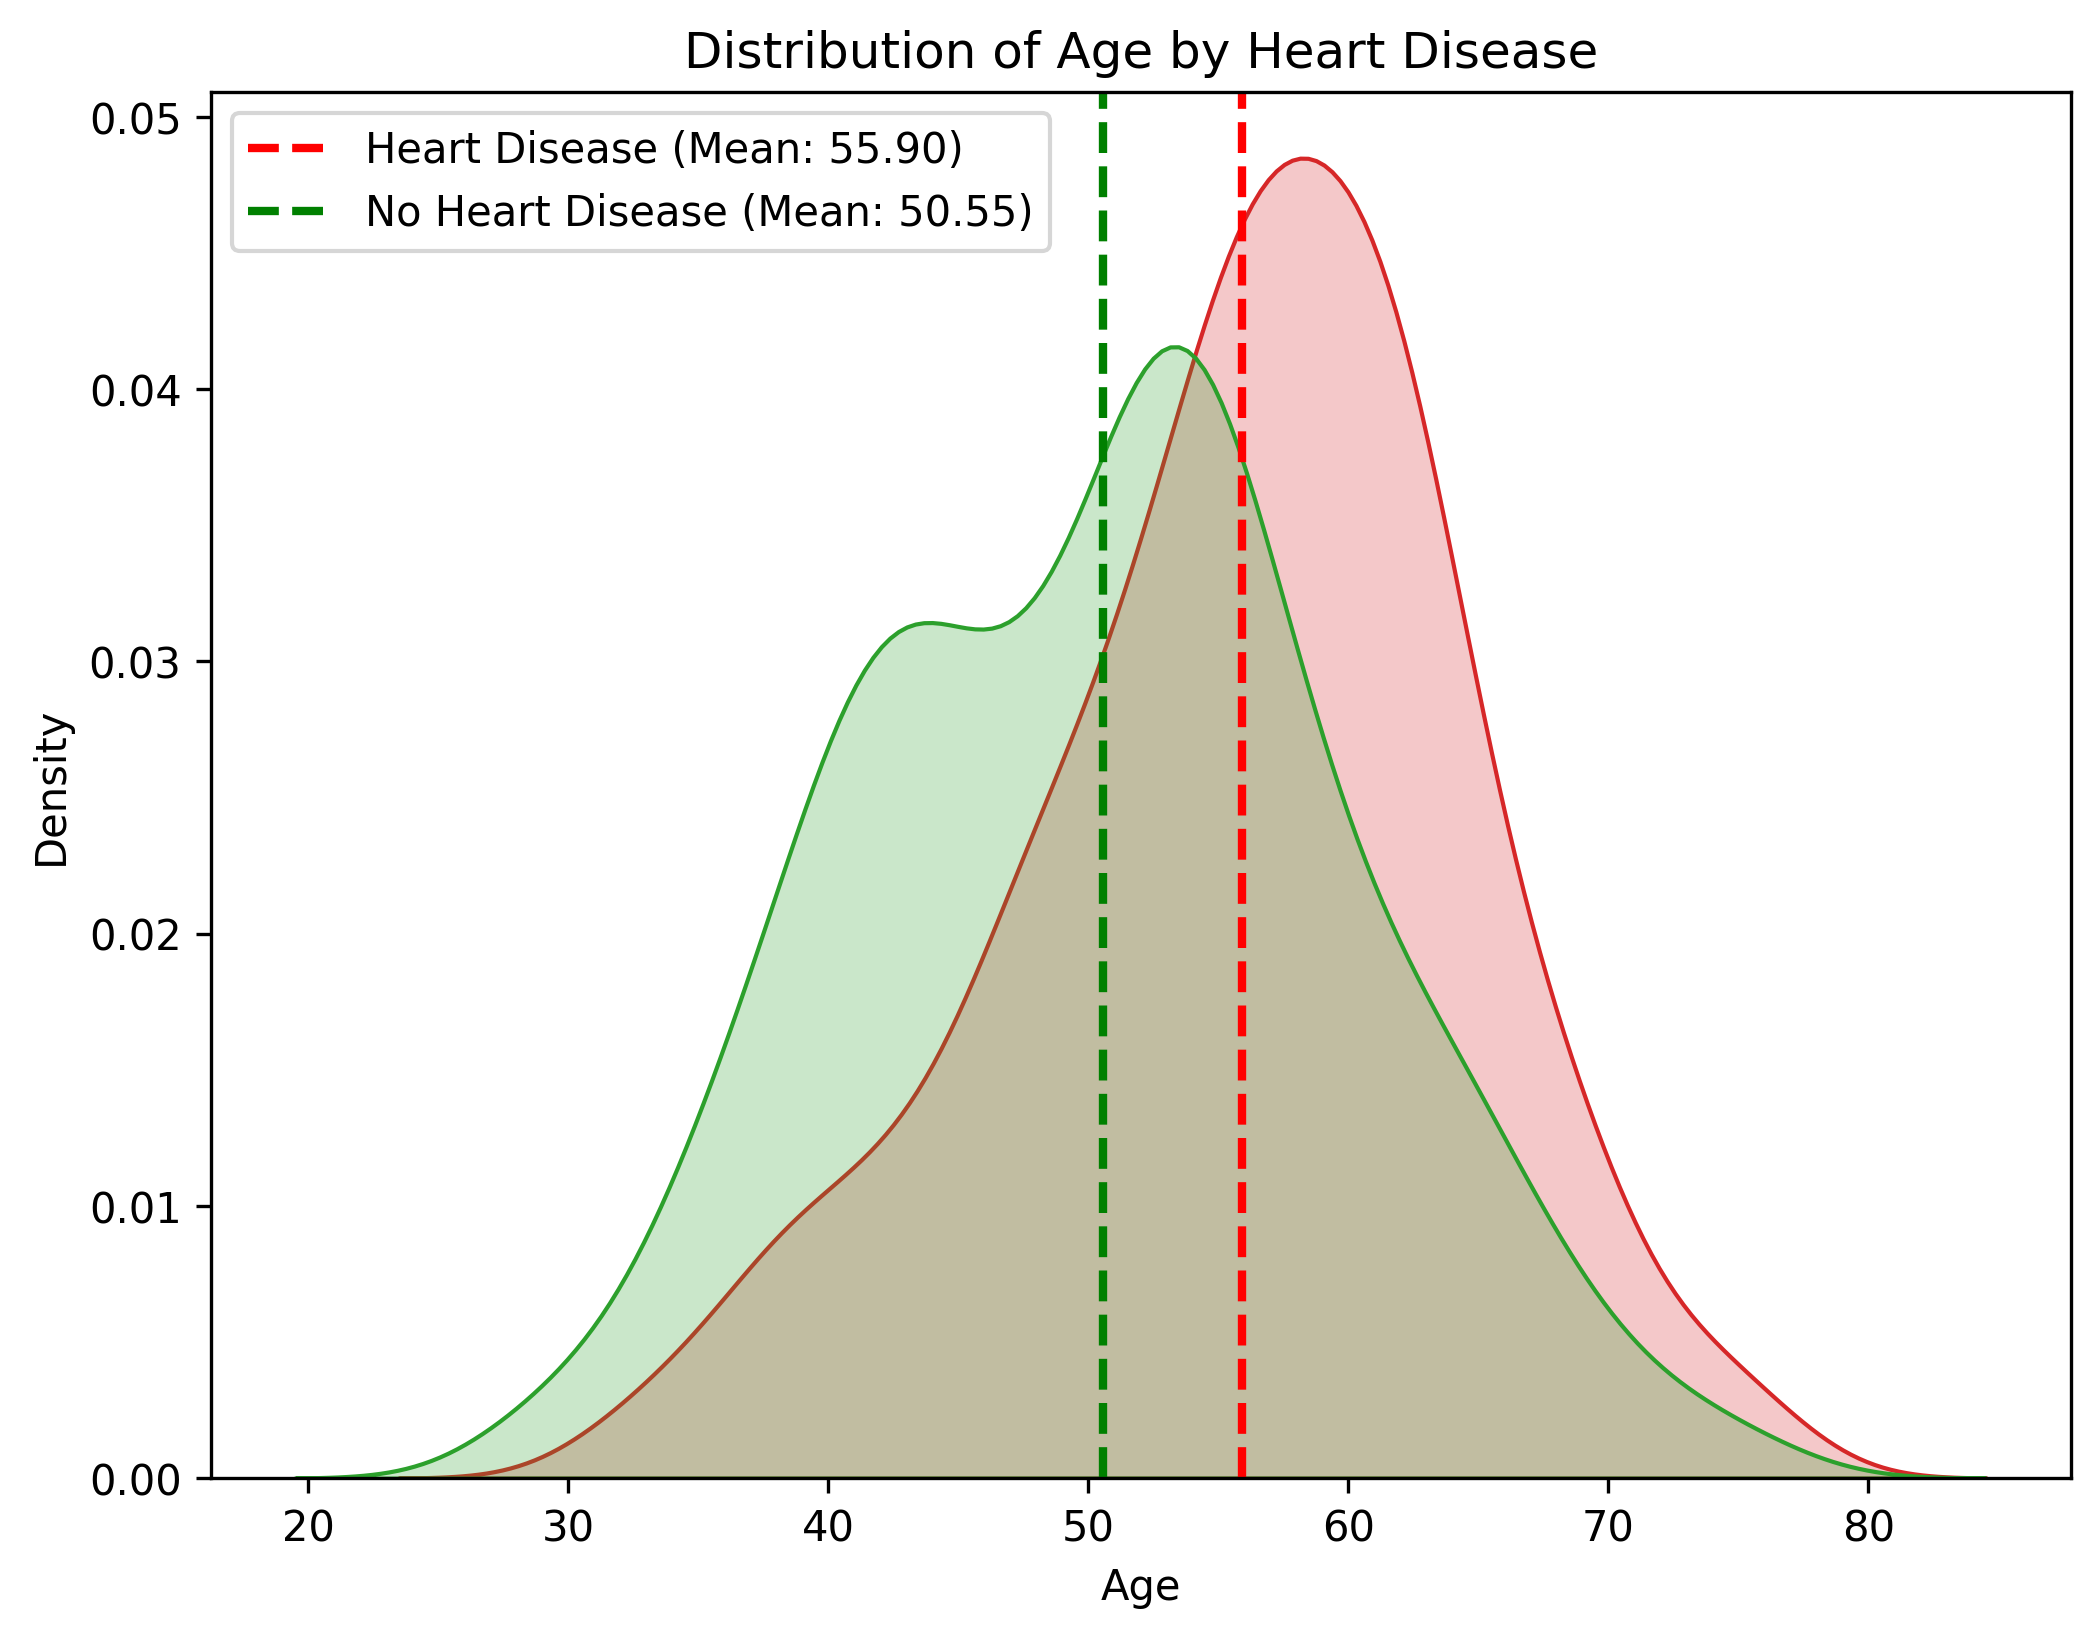

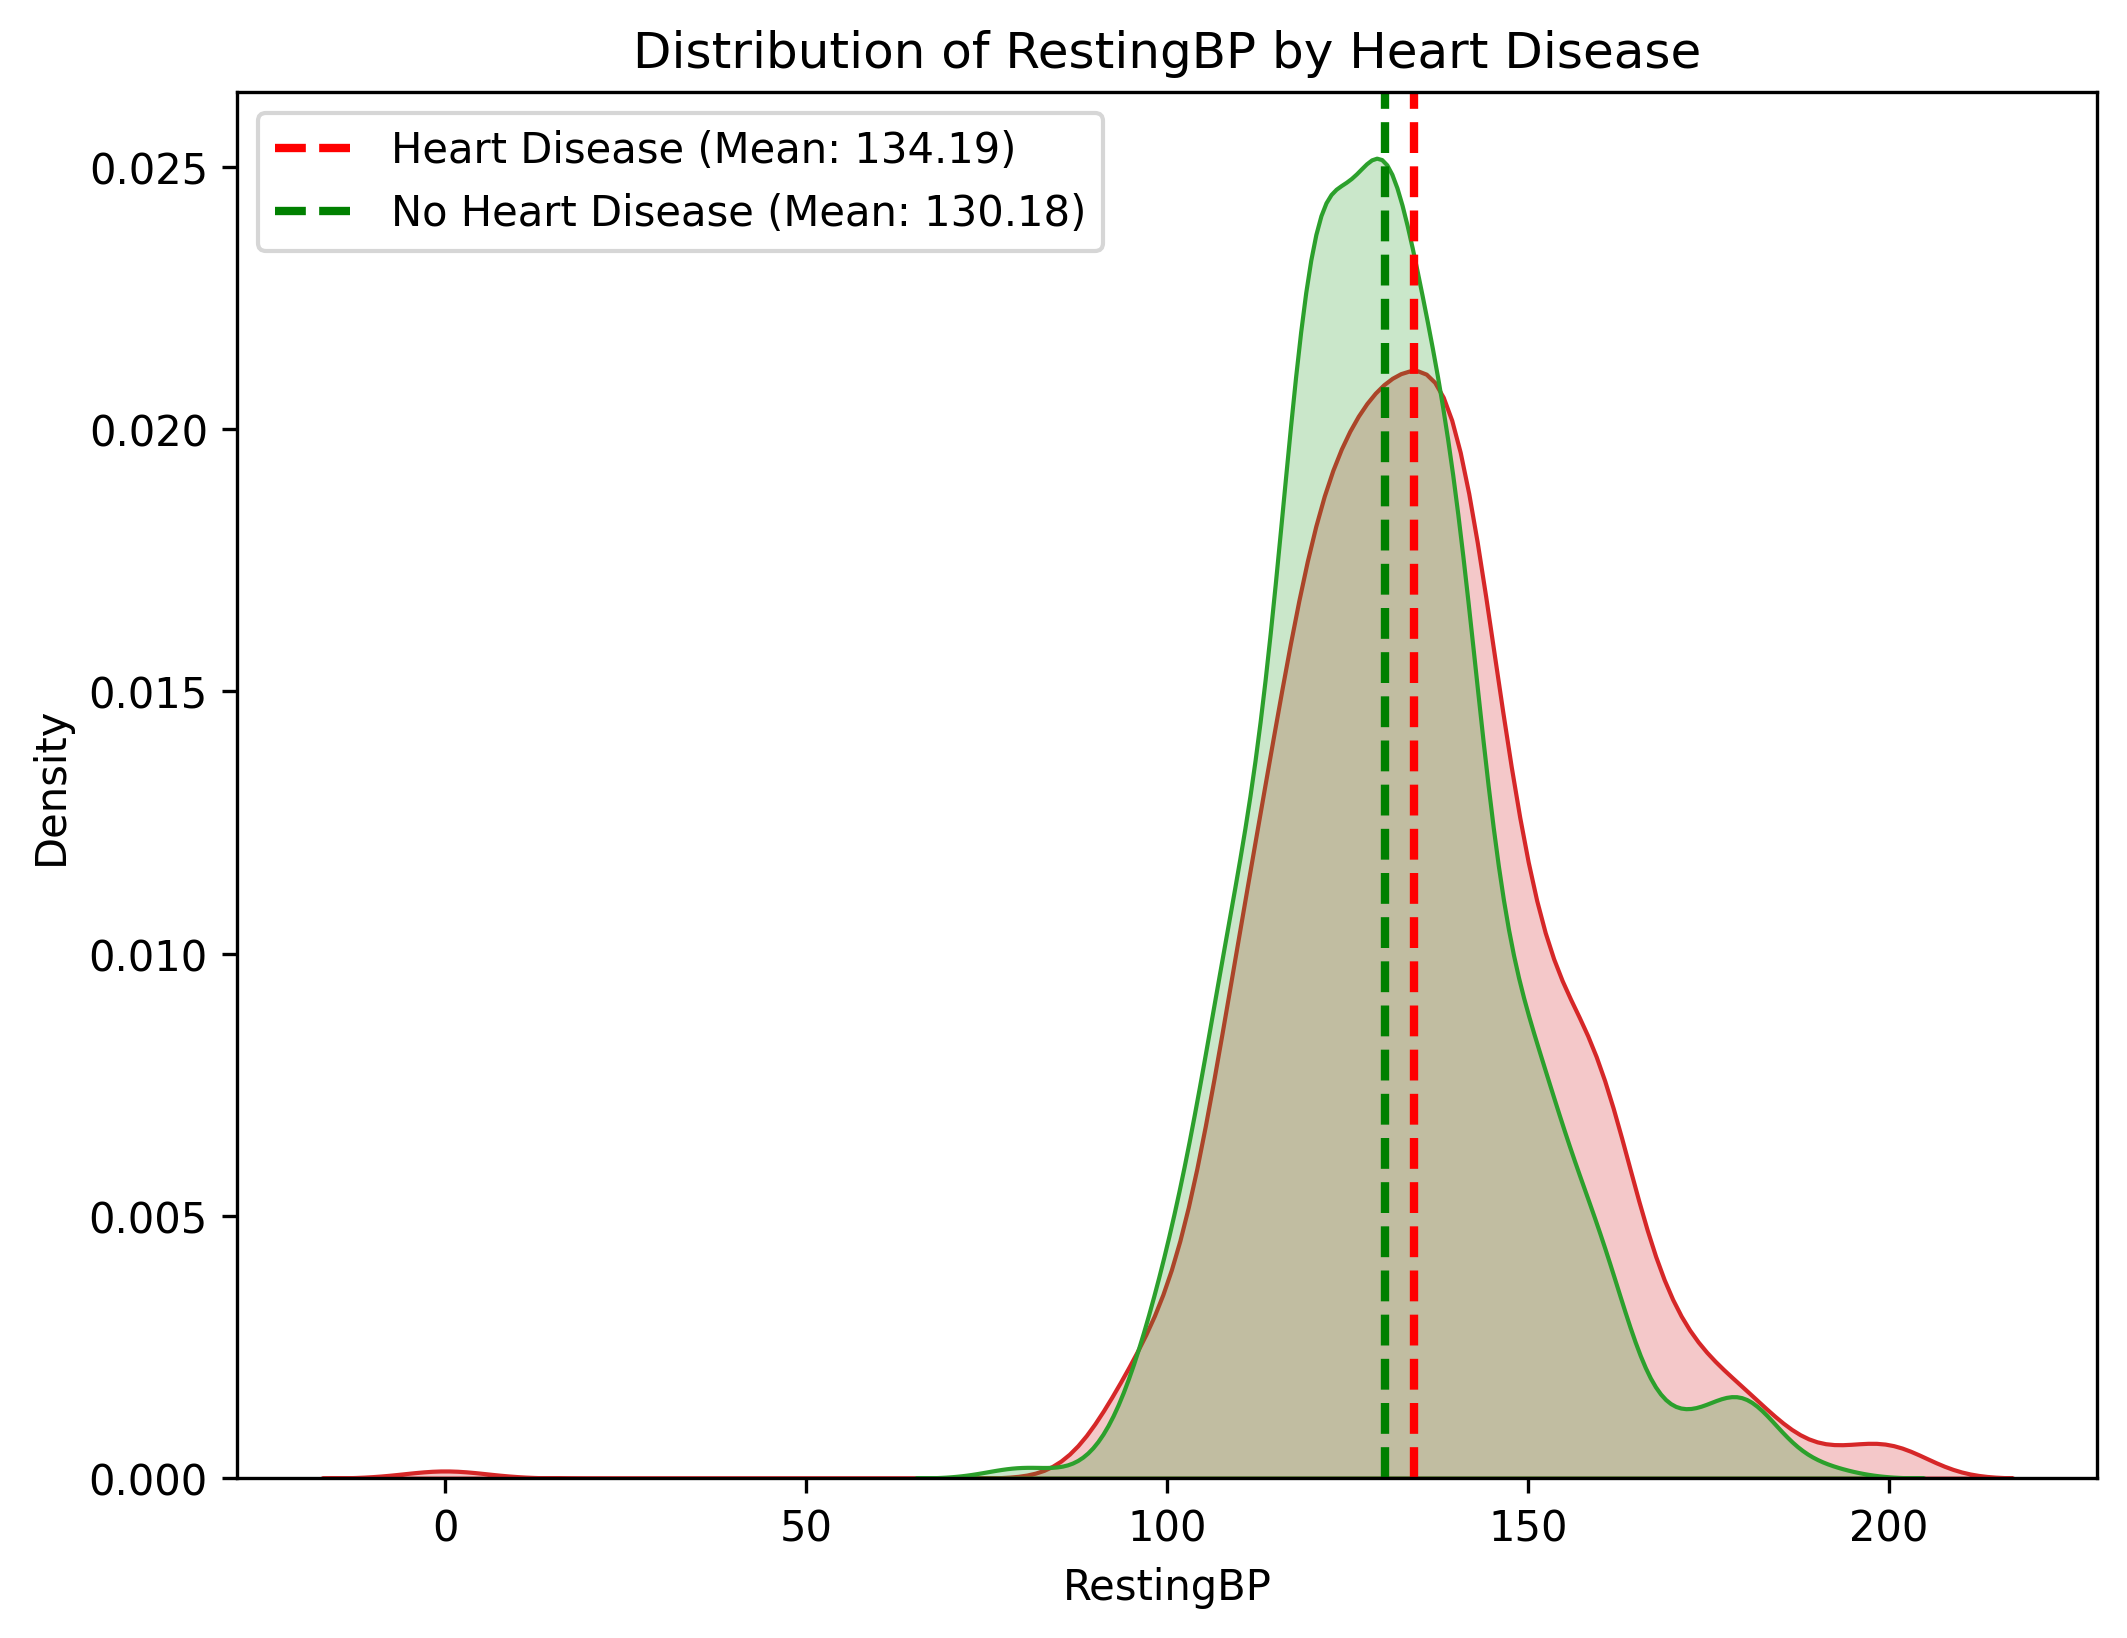

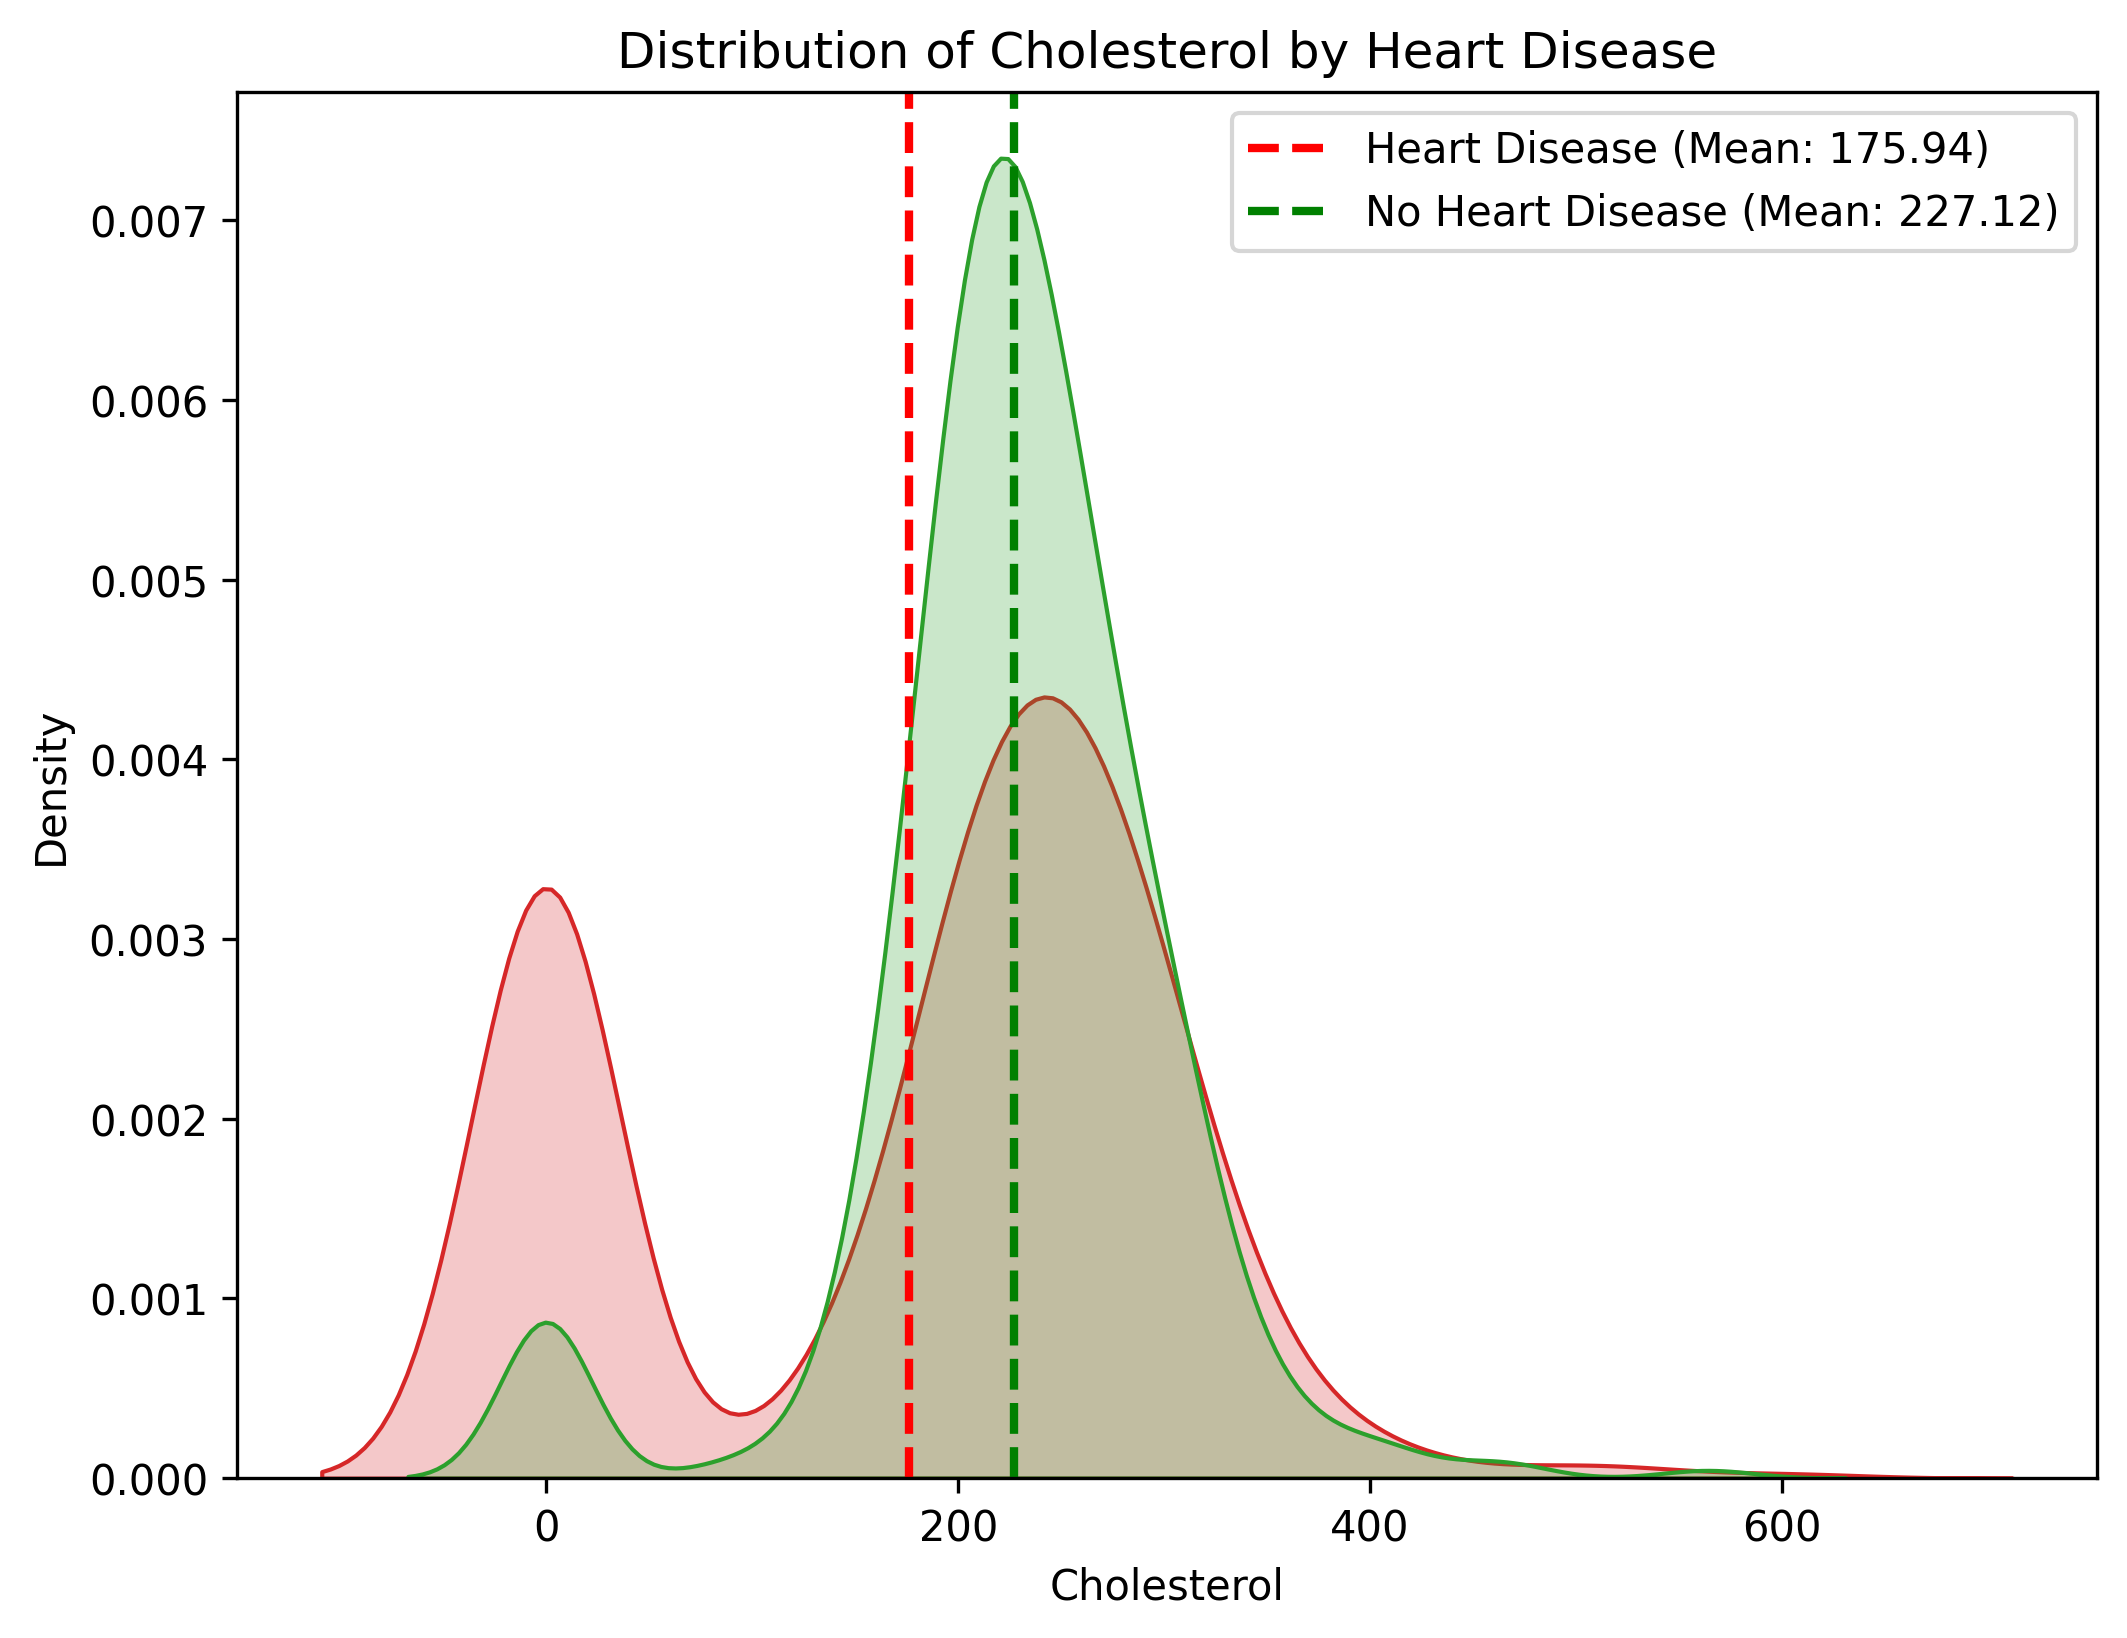

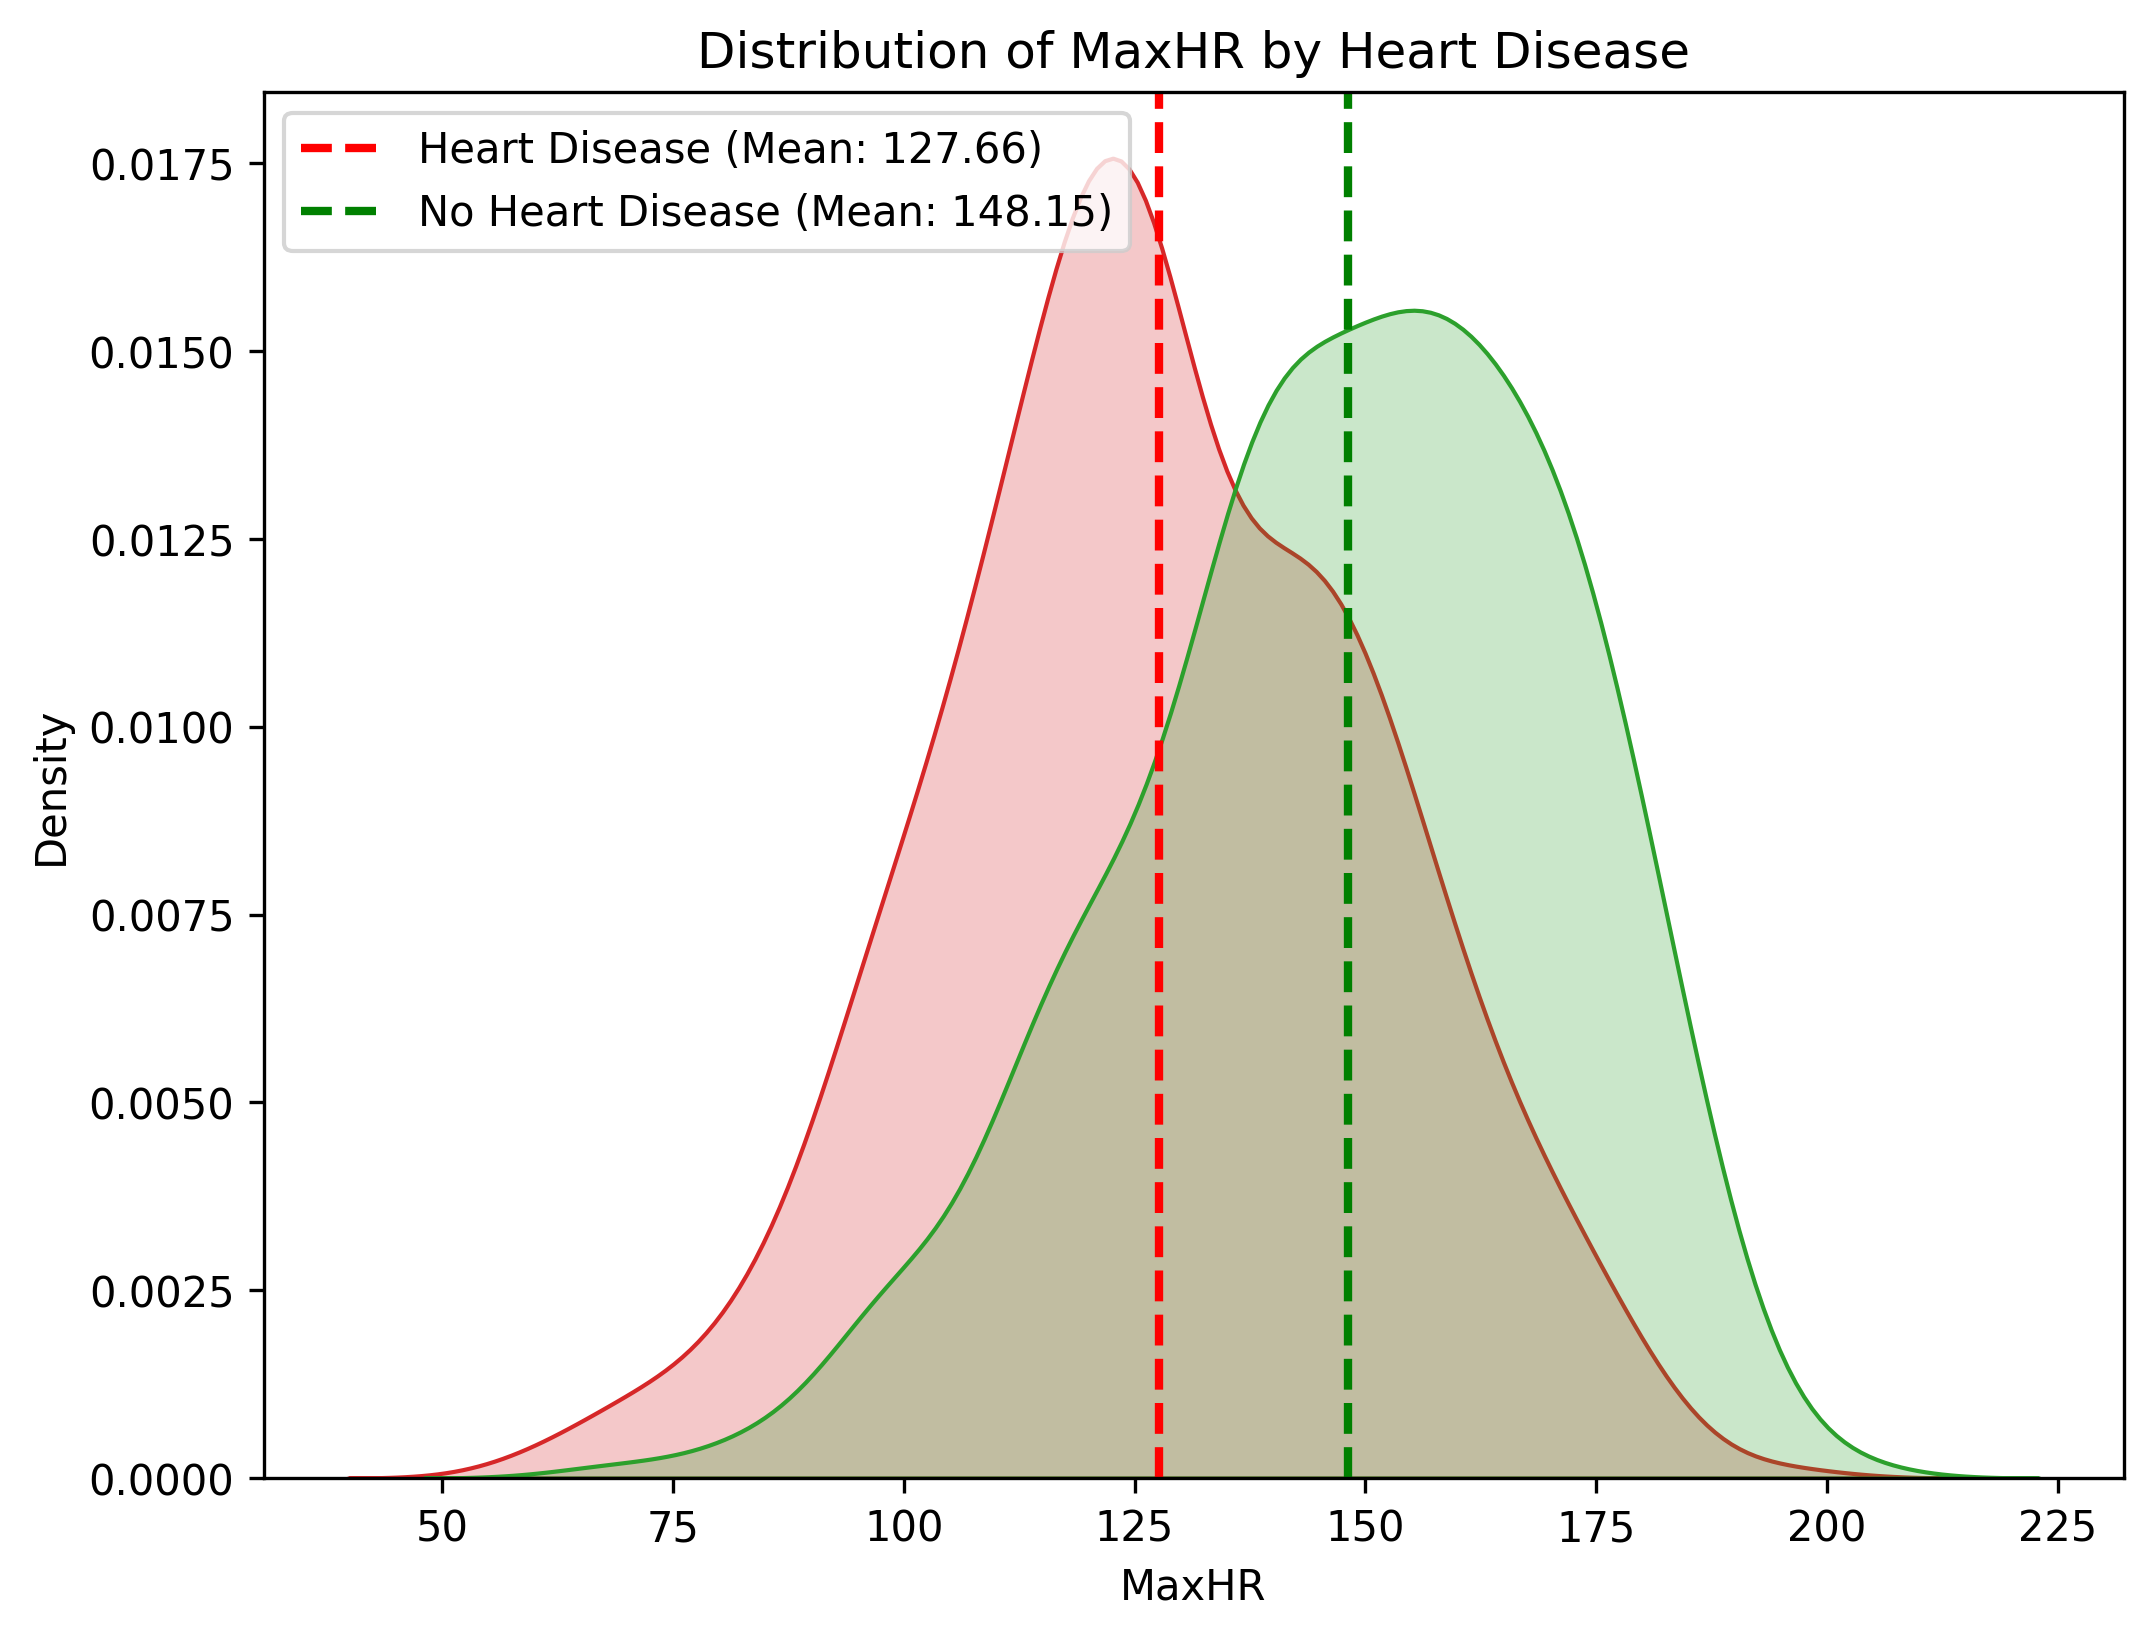

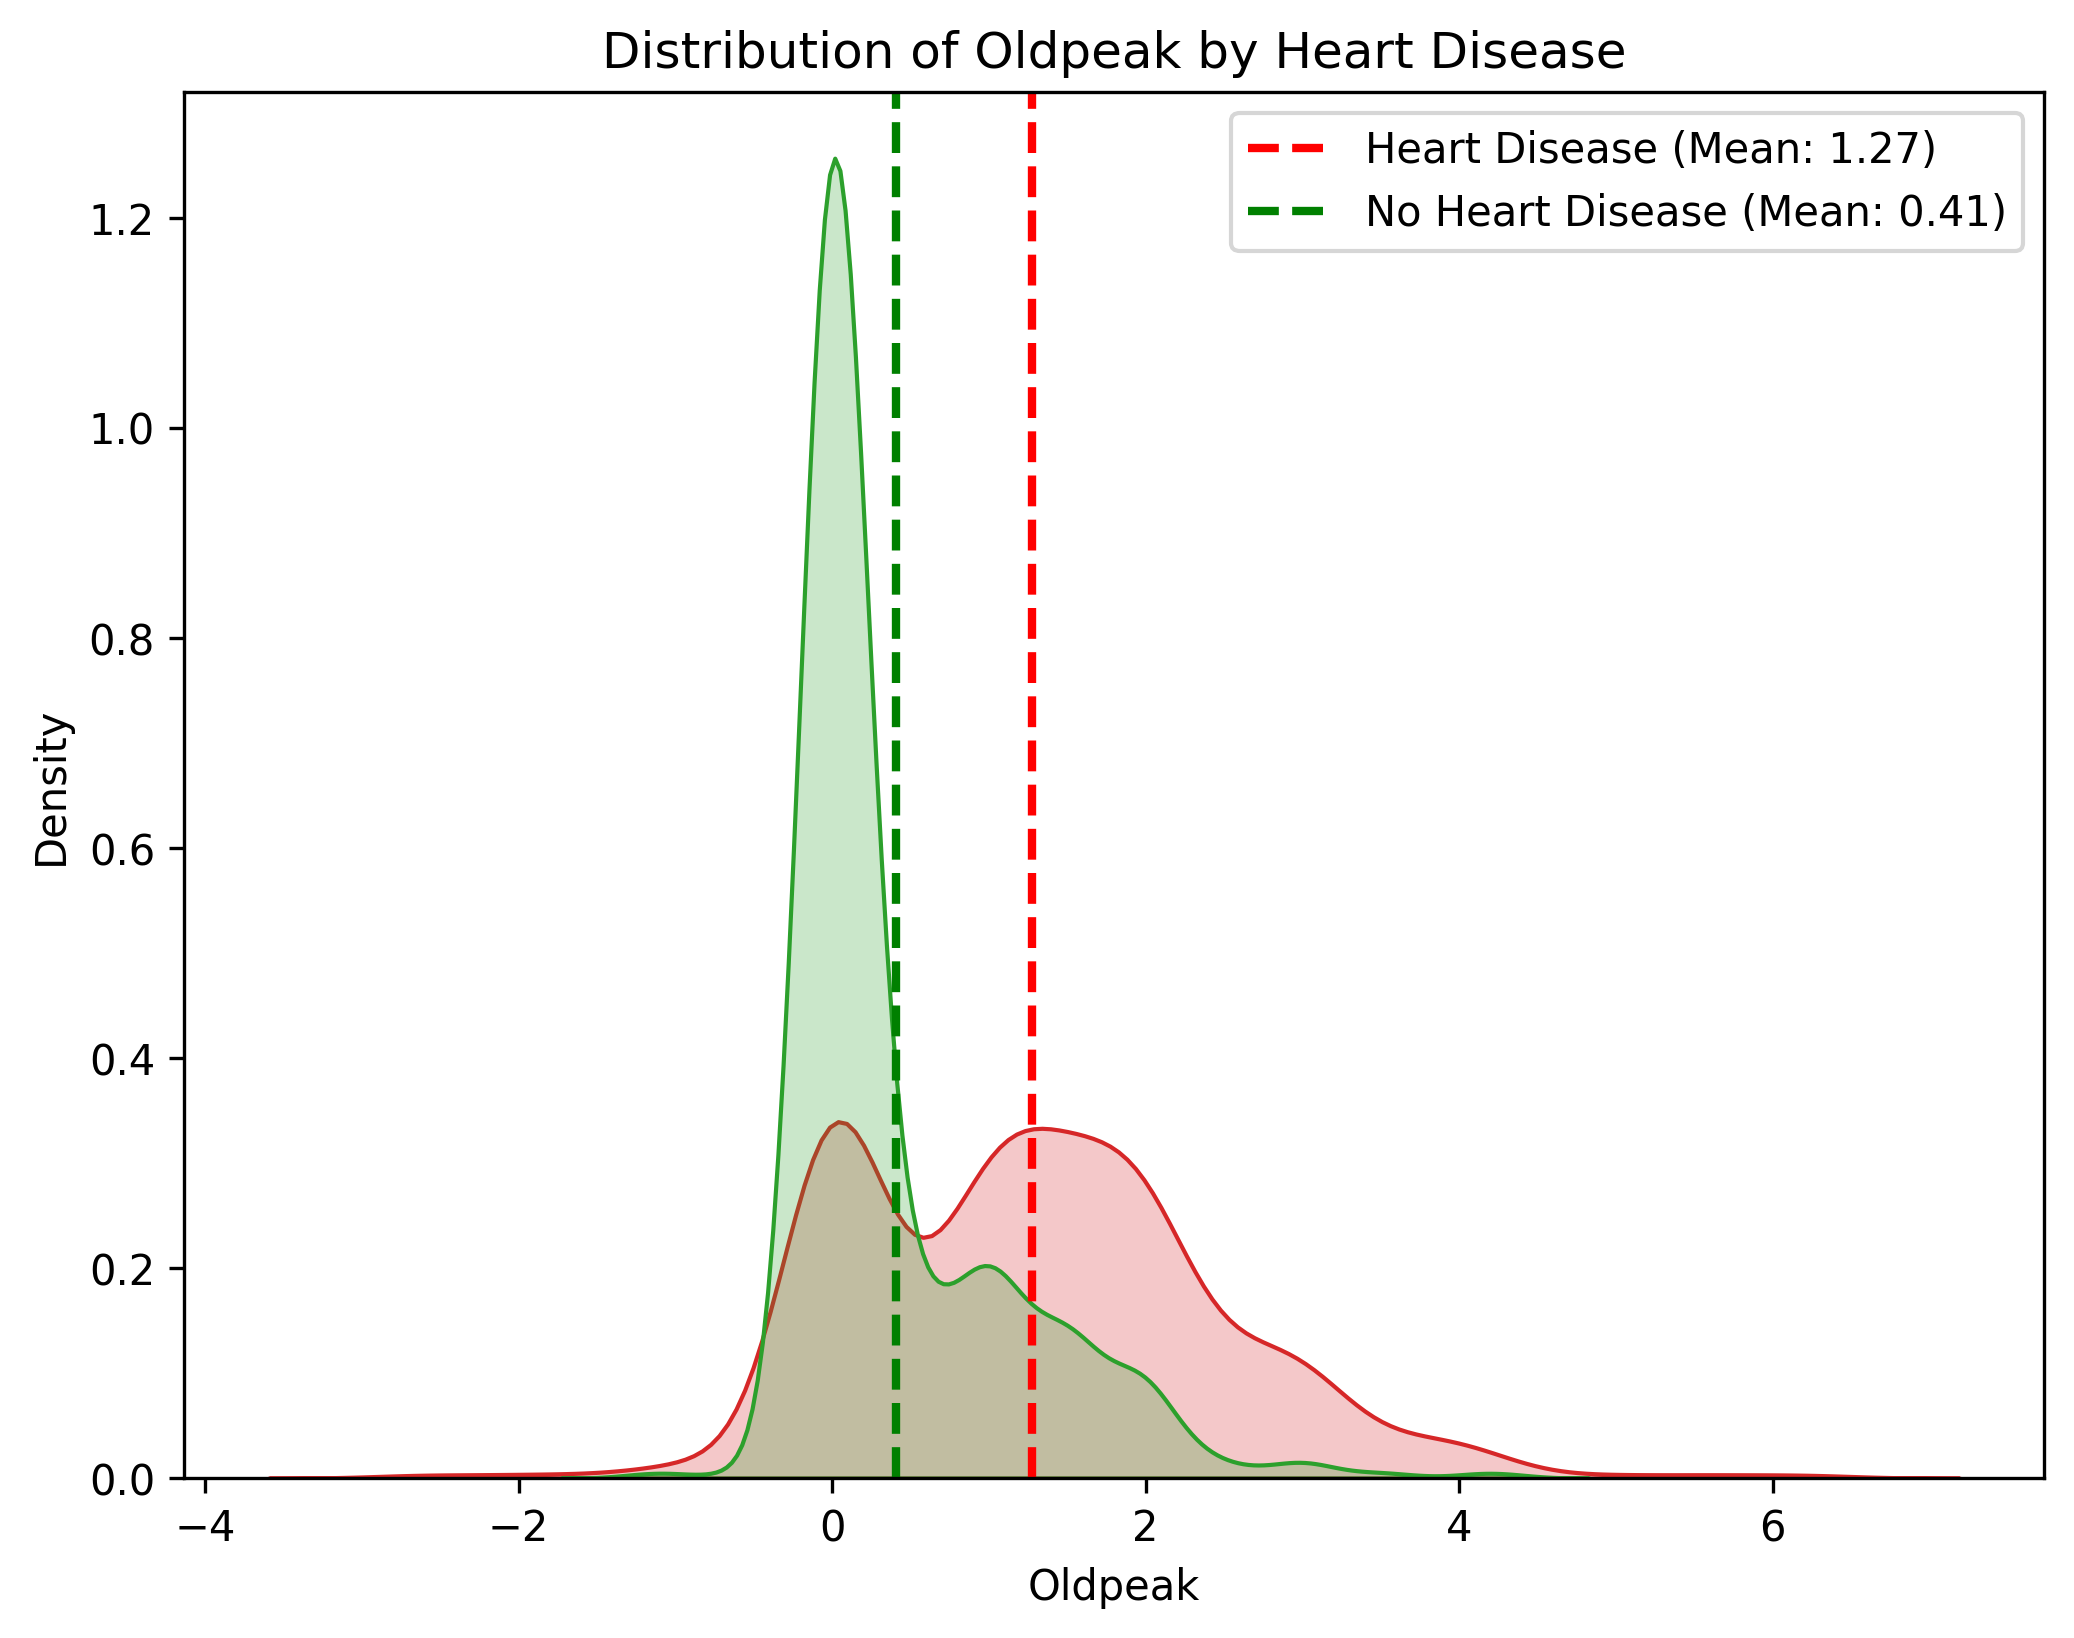

In [26]:
num_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

color_no_hd = "#2ca02c"  # Green (No Heart Disease)
color_hd = "#d62728"  # Red (Heart Disease)
palette = {0: color_no_hd, 1: color_hd}

for col in num_cols:
    plt.figure(figsize=(8, 6), dpi=300)
    sns.kdeplot(data=df, x=col, hue='HeartDisease', fill=True, common_norm=False, palette=palette)

    mean_hd = df[df['HeartDisease'] == 1][col].mean()  # Mean for Heart Disease
    mean_no_hd = df[df['HeartDisease'] == 0][col].mean()  # Mean for No Heart Disease

    plt.axvline(mean_hd, color="red", linestyle="dashed", linewidth=2, label=f'Heart Disease (Mean: {mean_hd:.2f})')
    plt.axvline(mean_no_hd, color="green", linestyle="dashed", linewidth=2, label=f'No Heart Disease (Mean: {mean_no_hd:.2f})')

    plt.legend()

    plt.title(f'Distribution of {col} by Heart Disease')
    plt.show()


# Categorical Features by HeartDisease

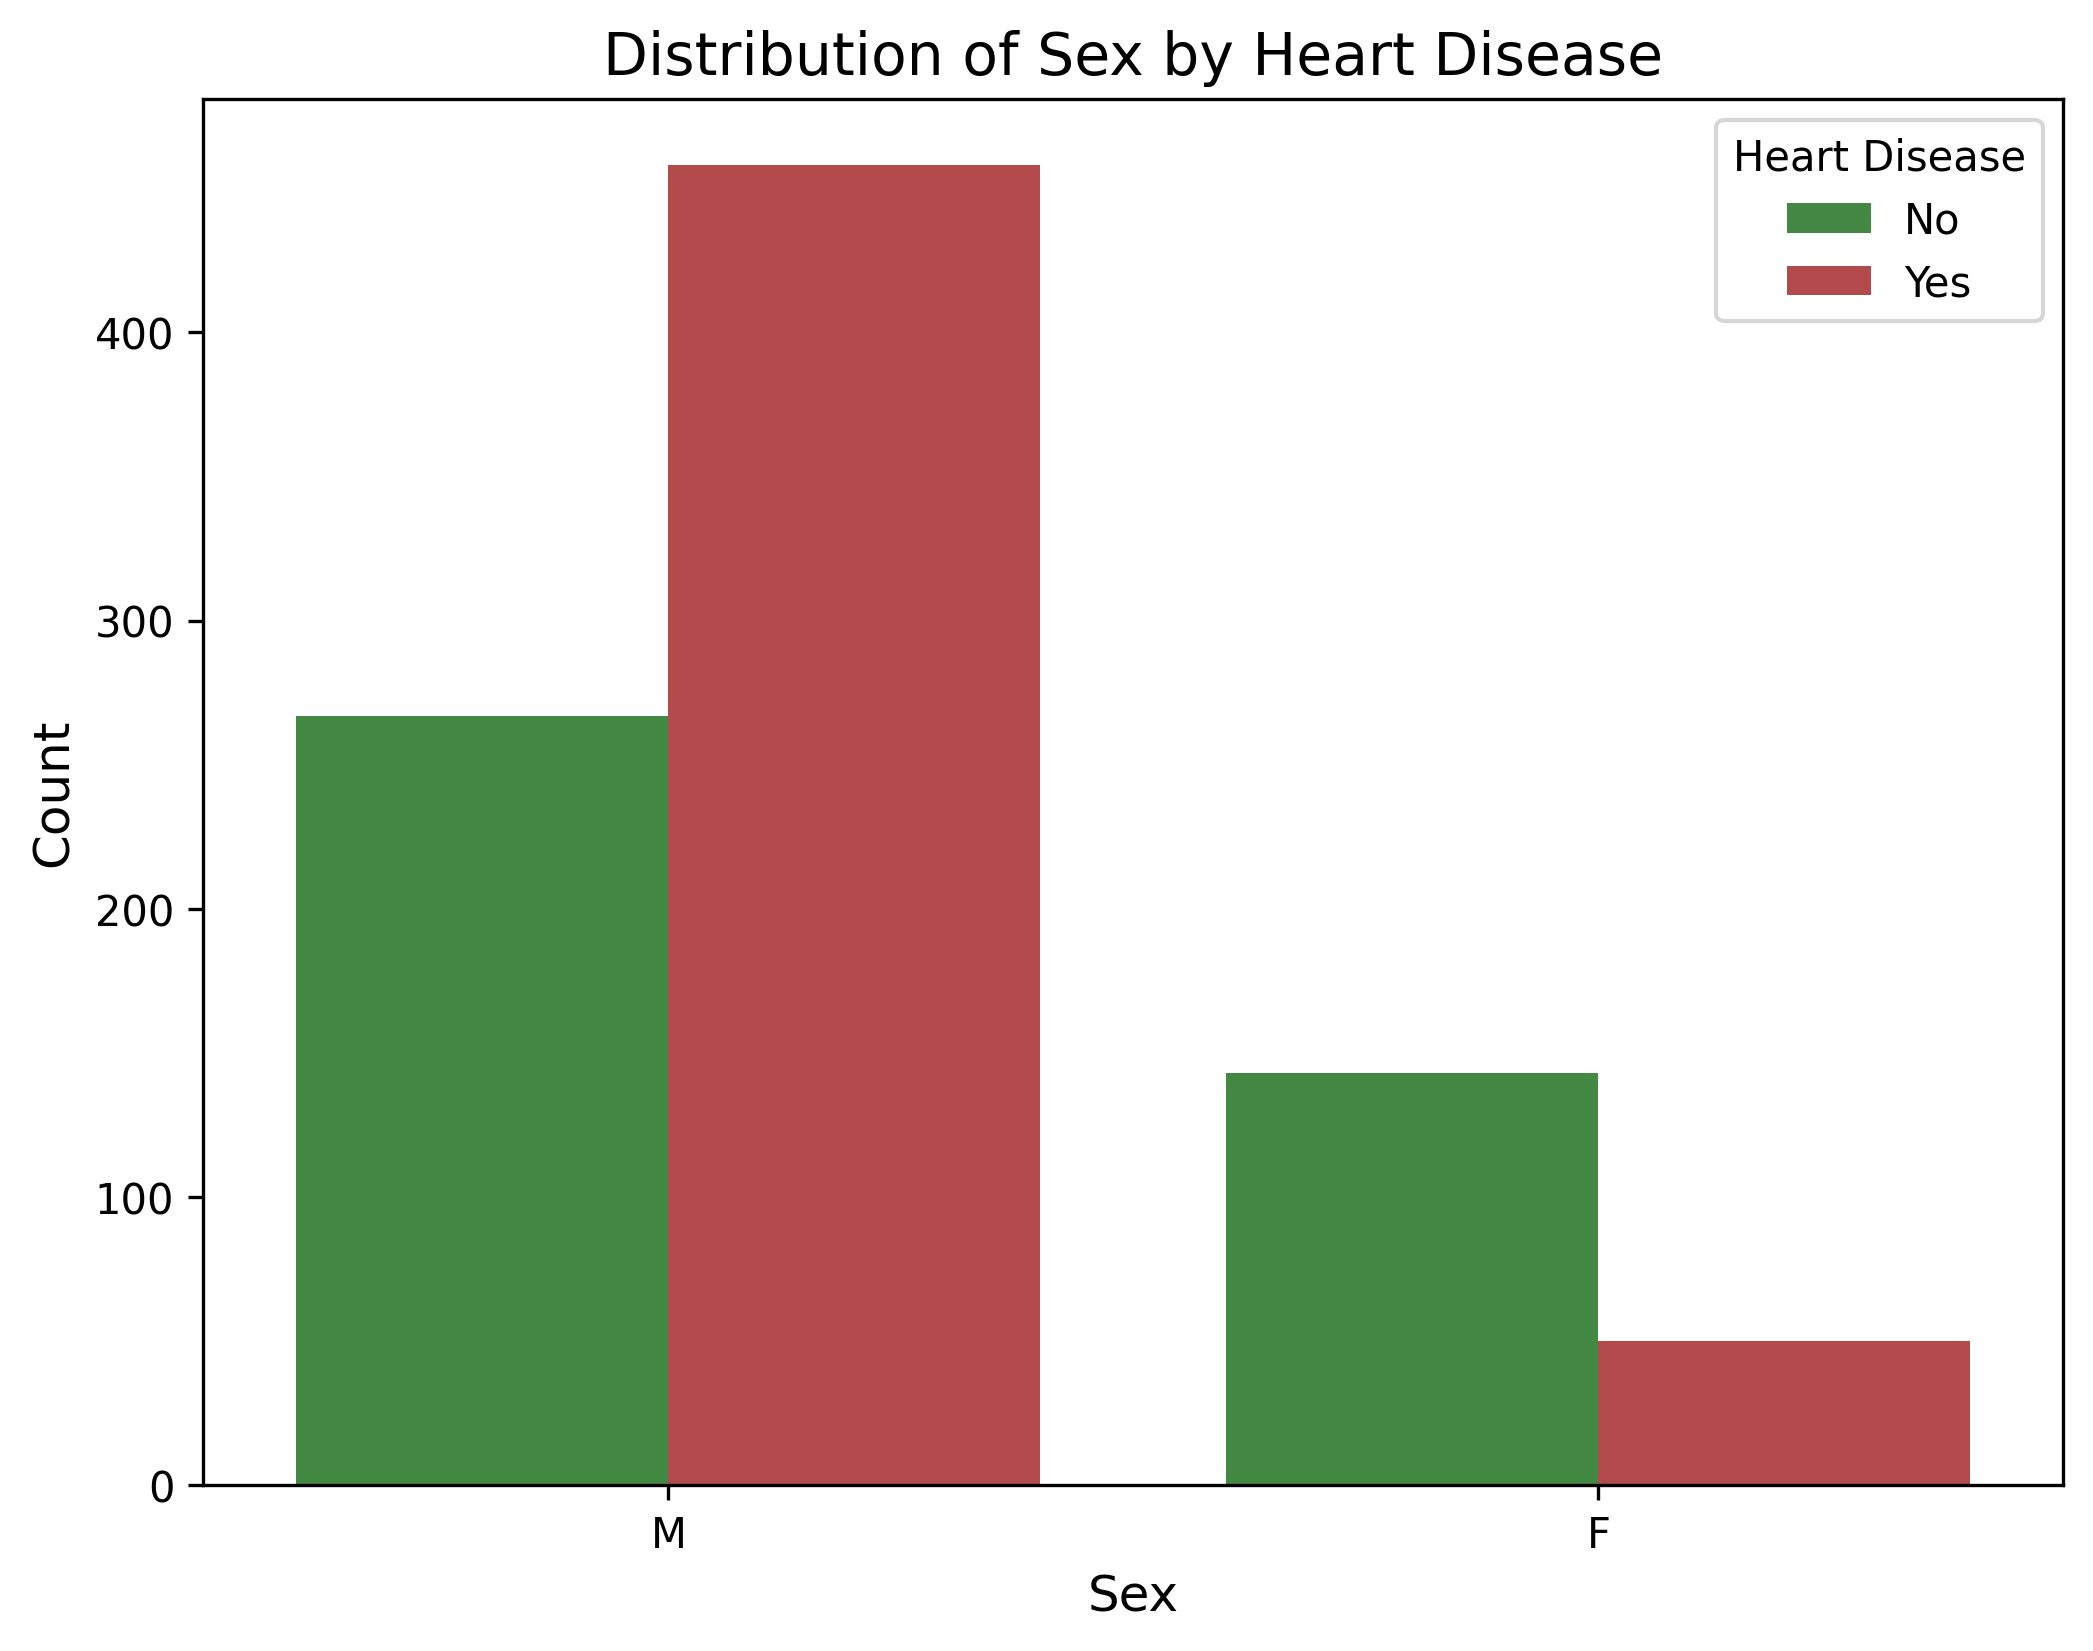

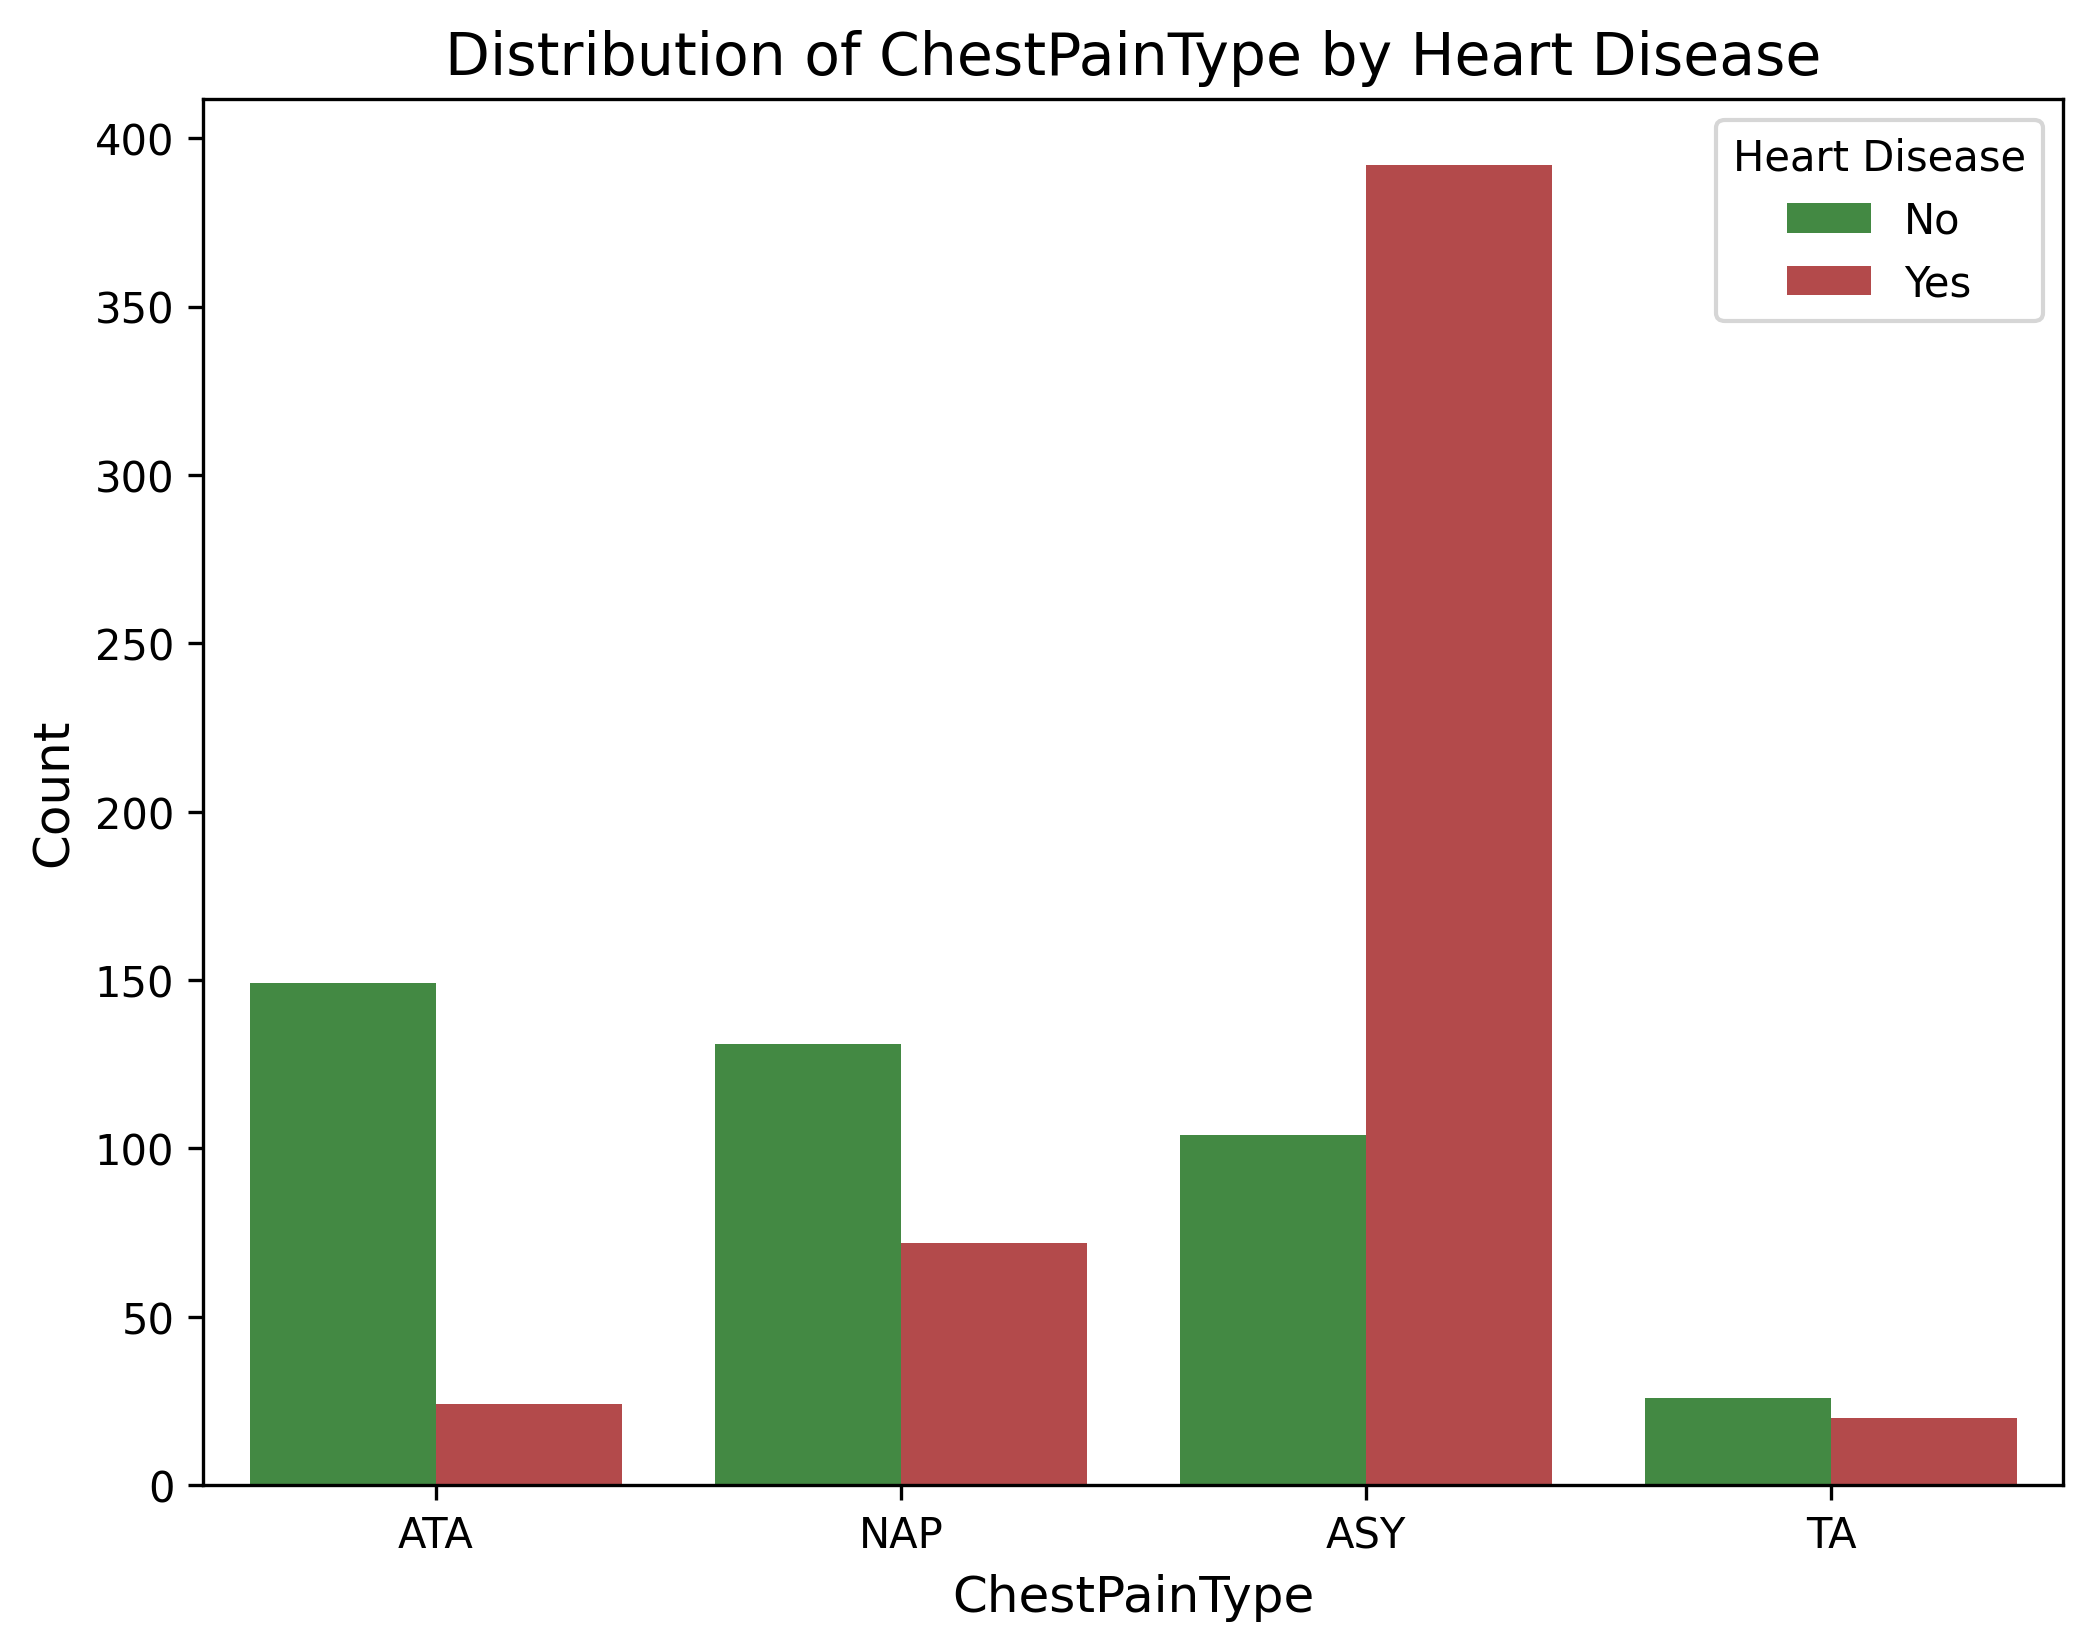

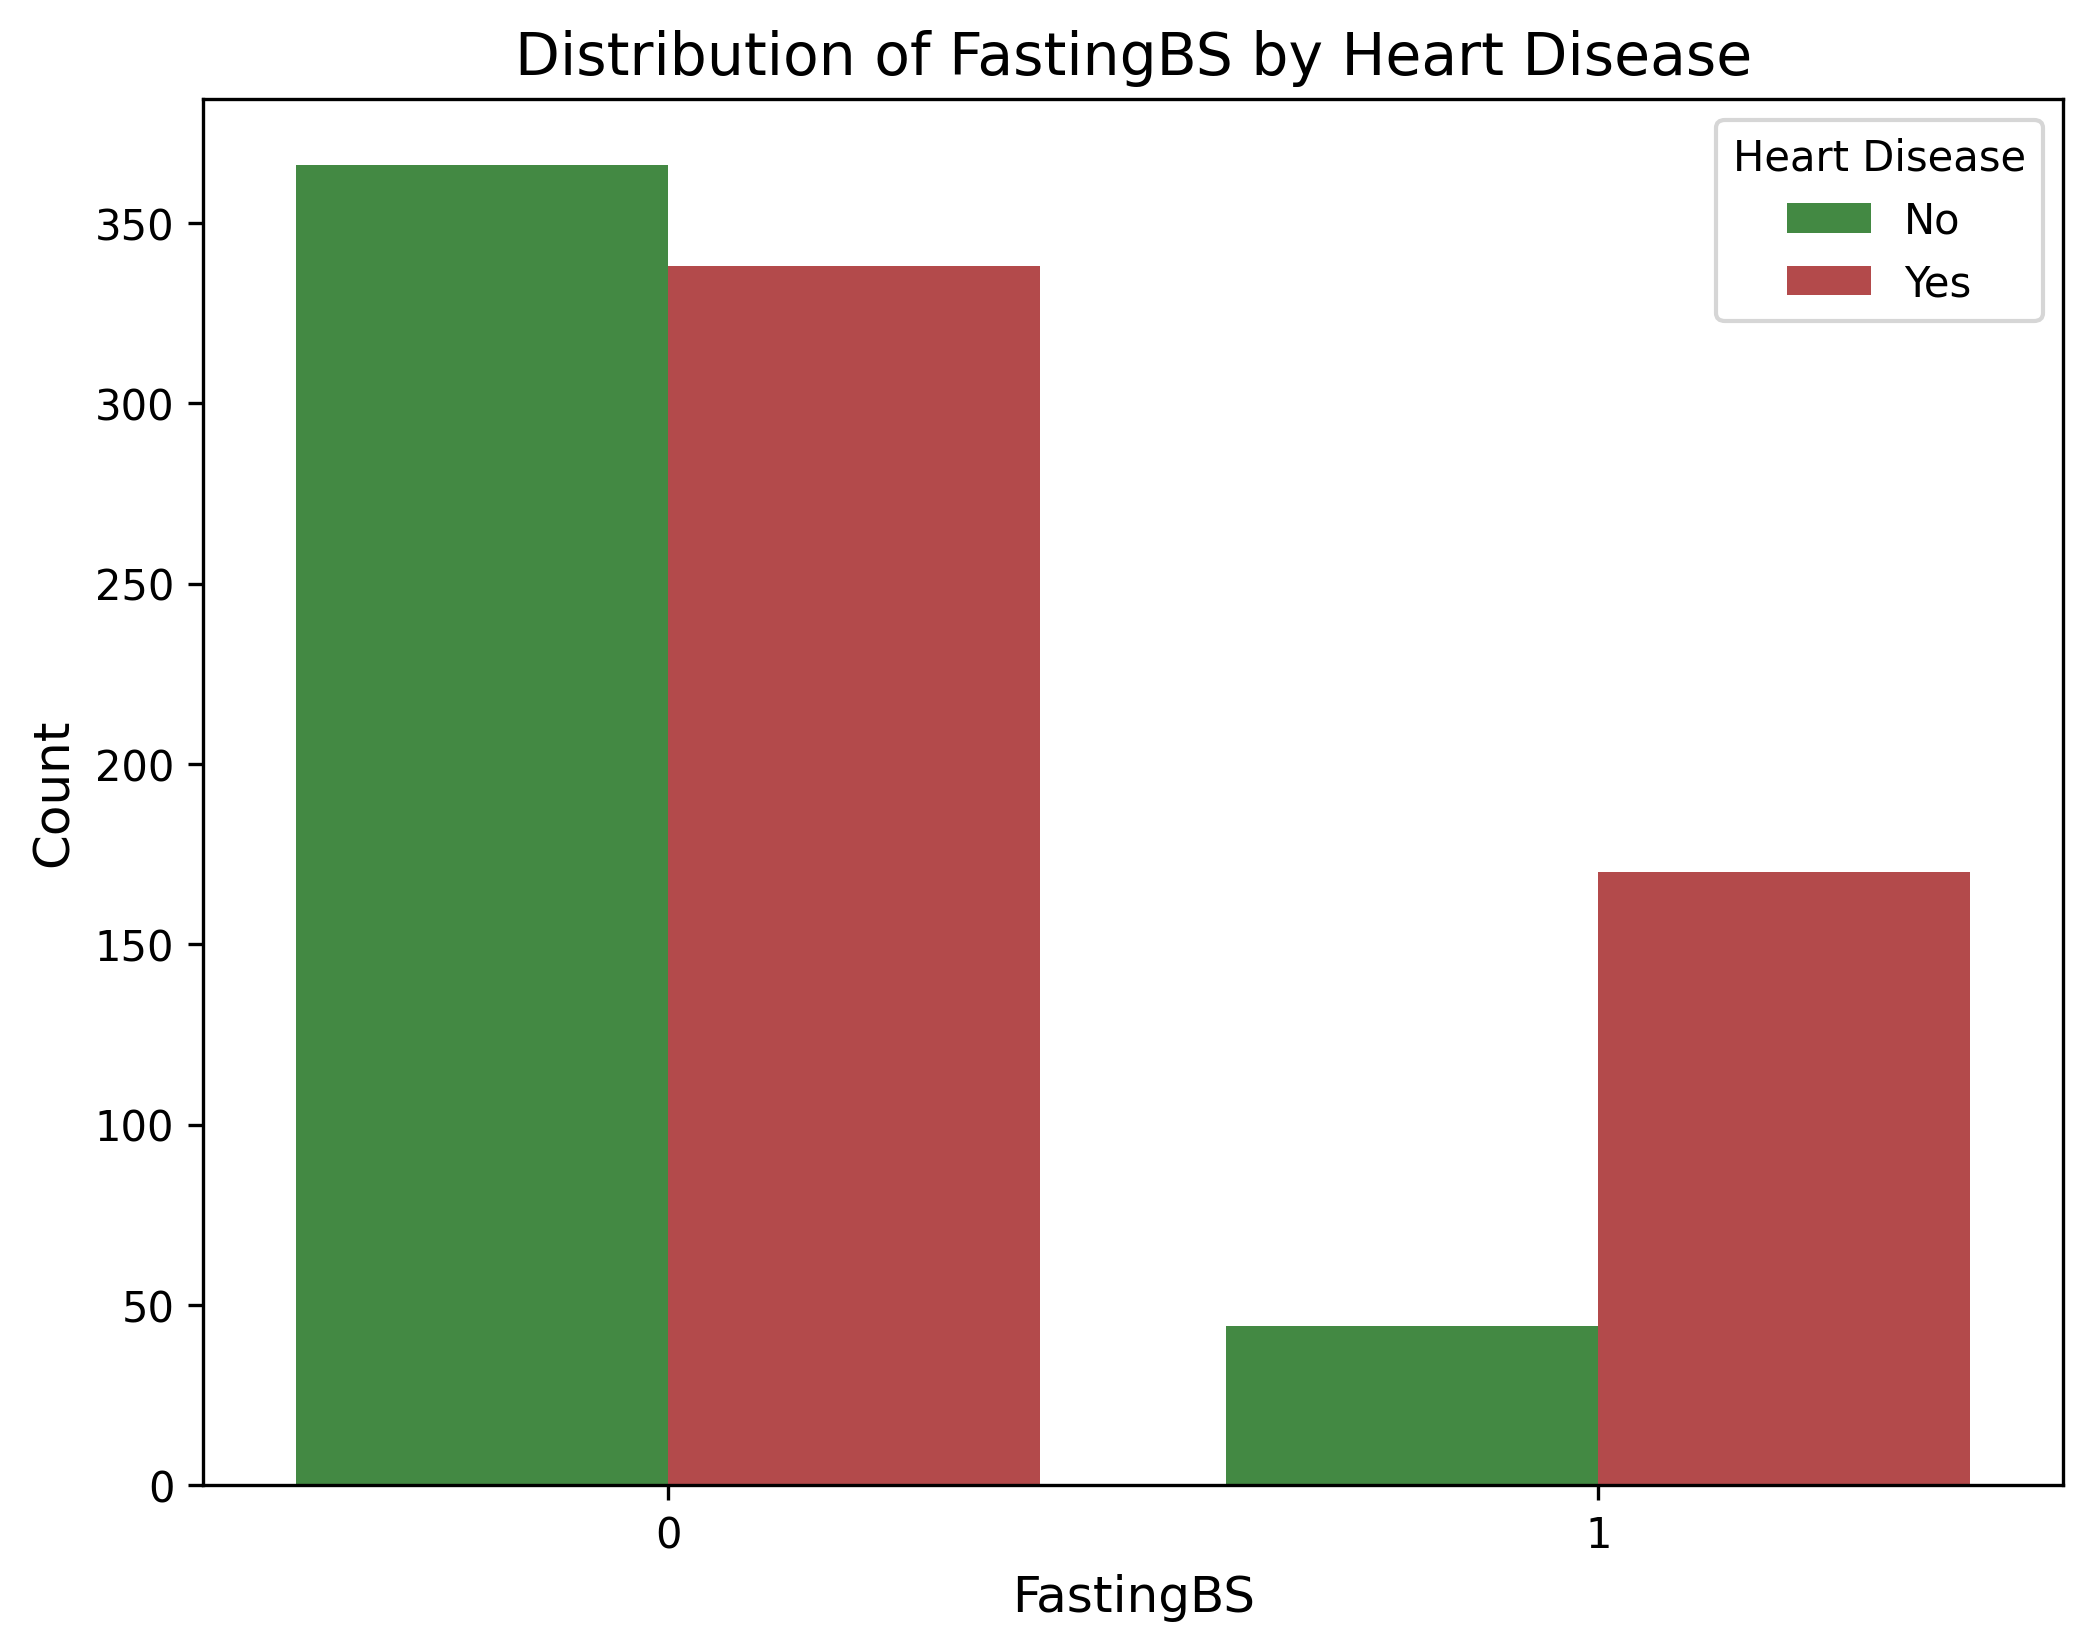

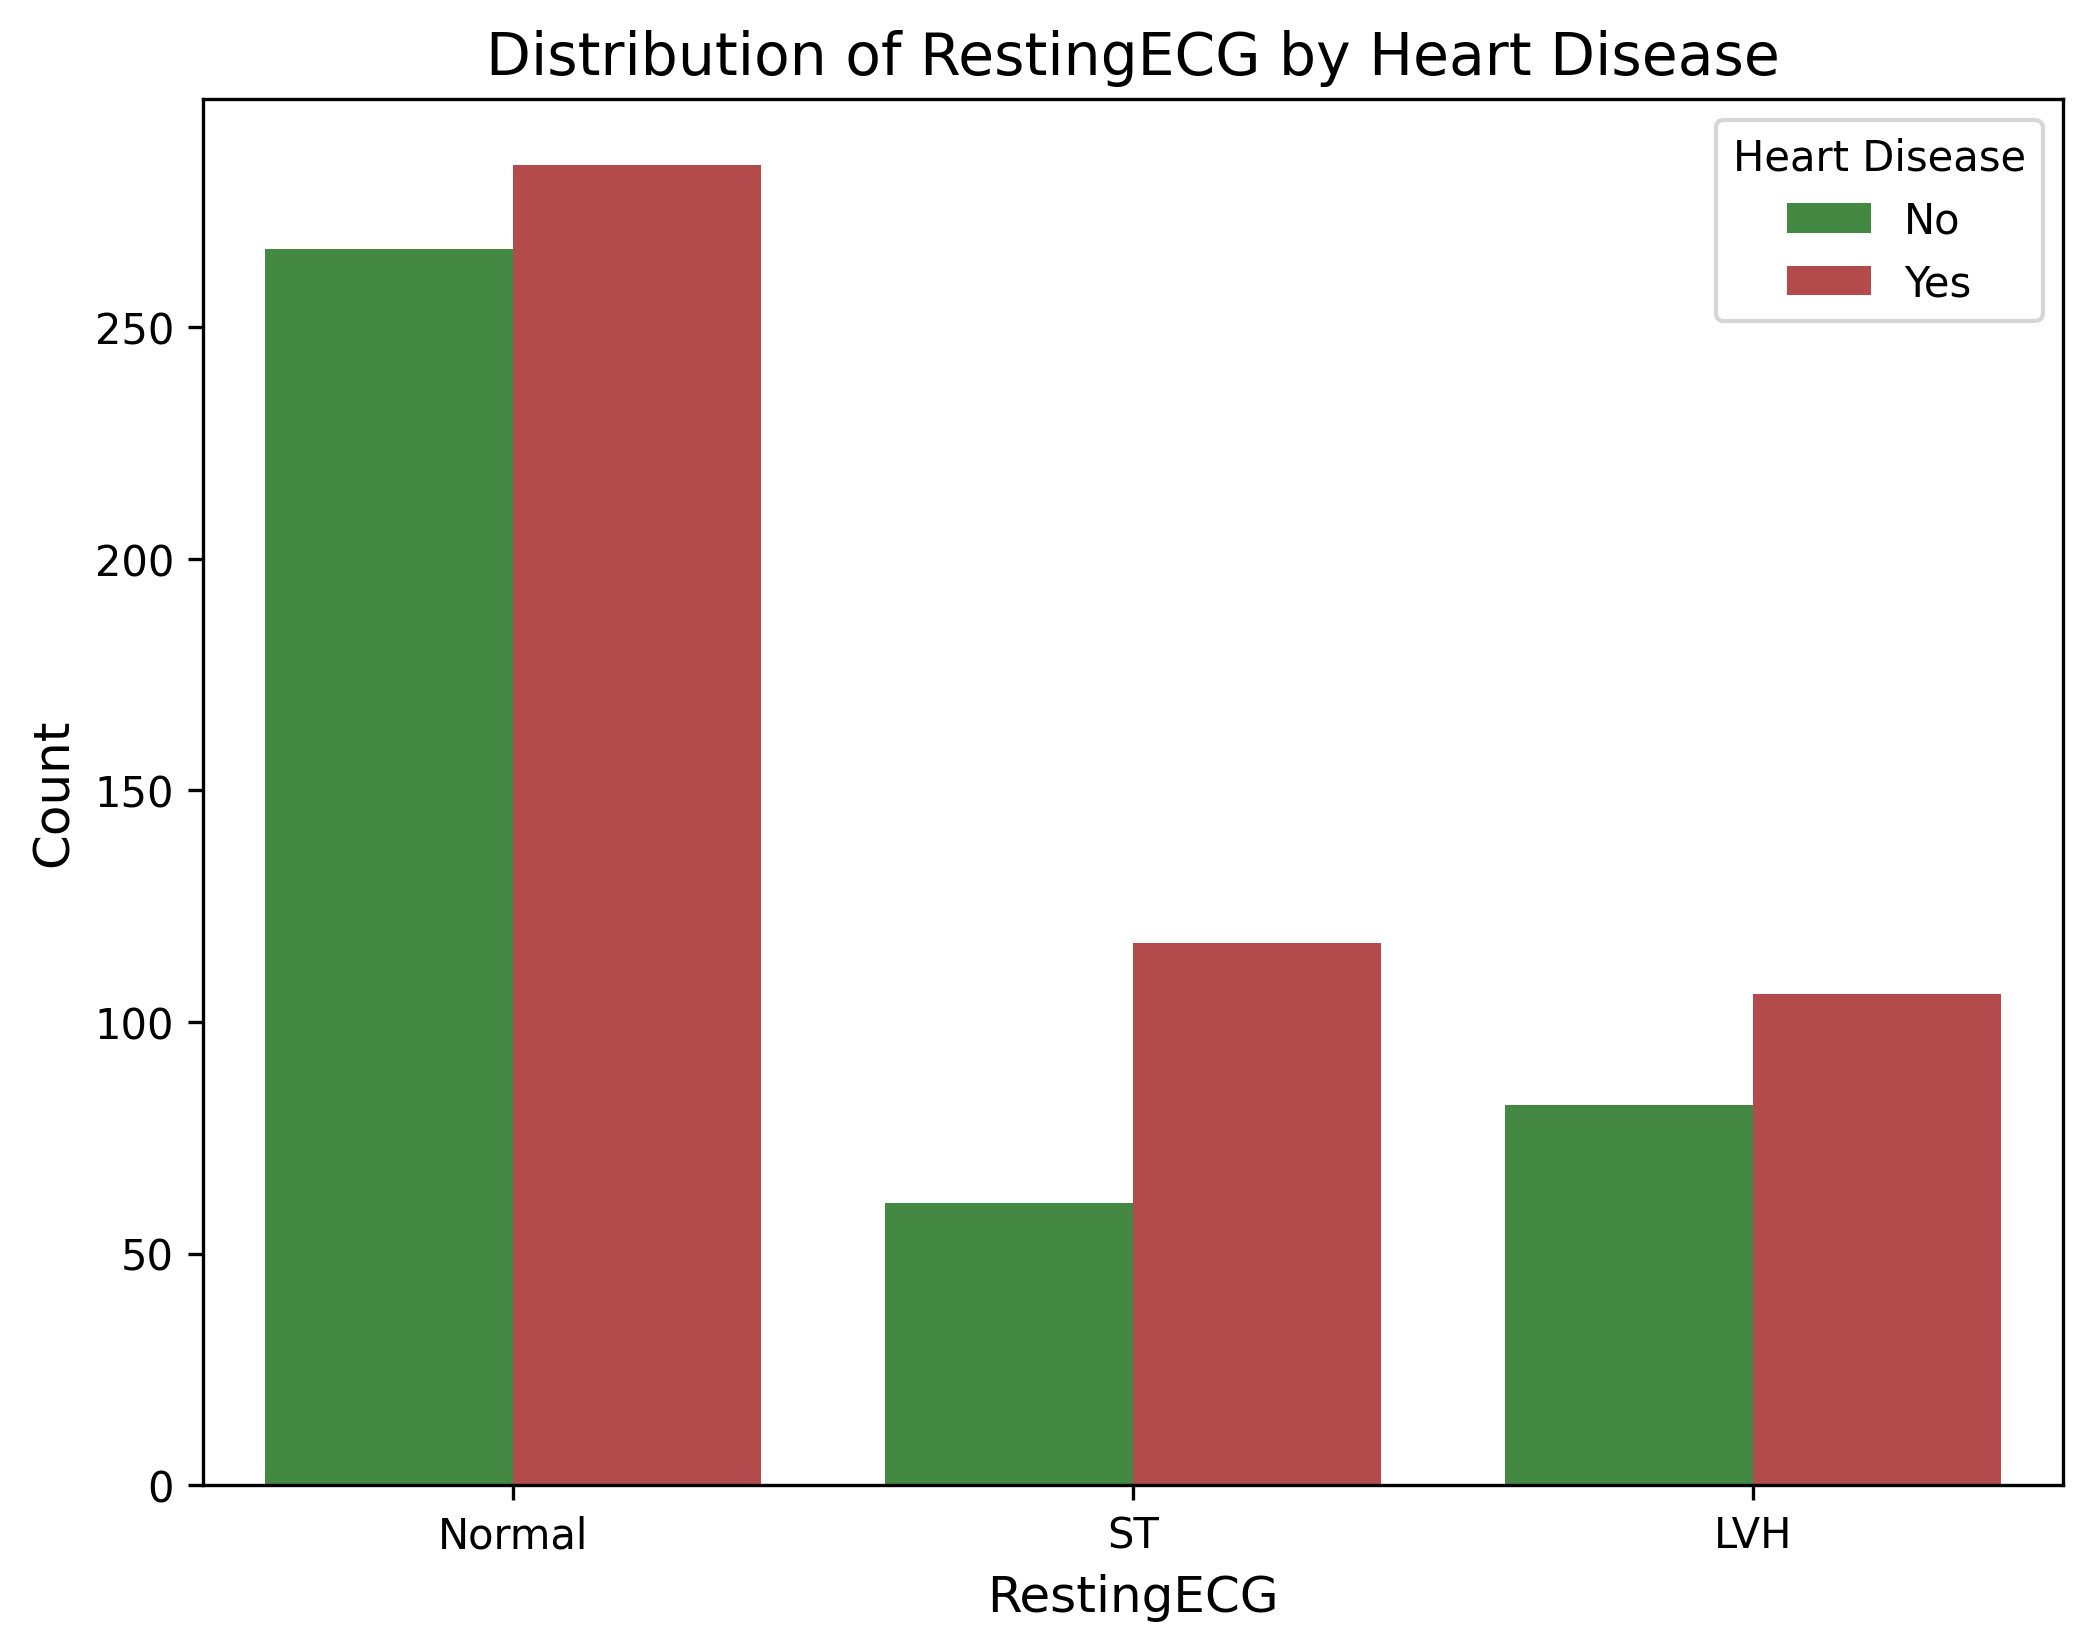

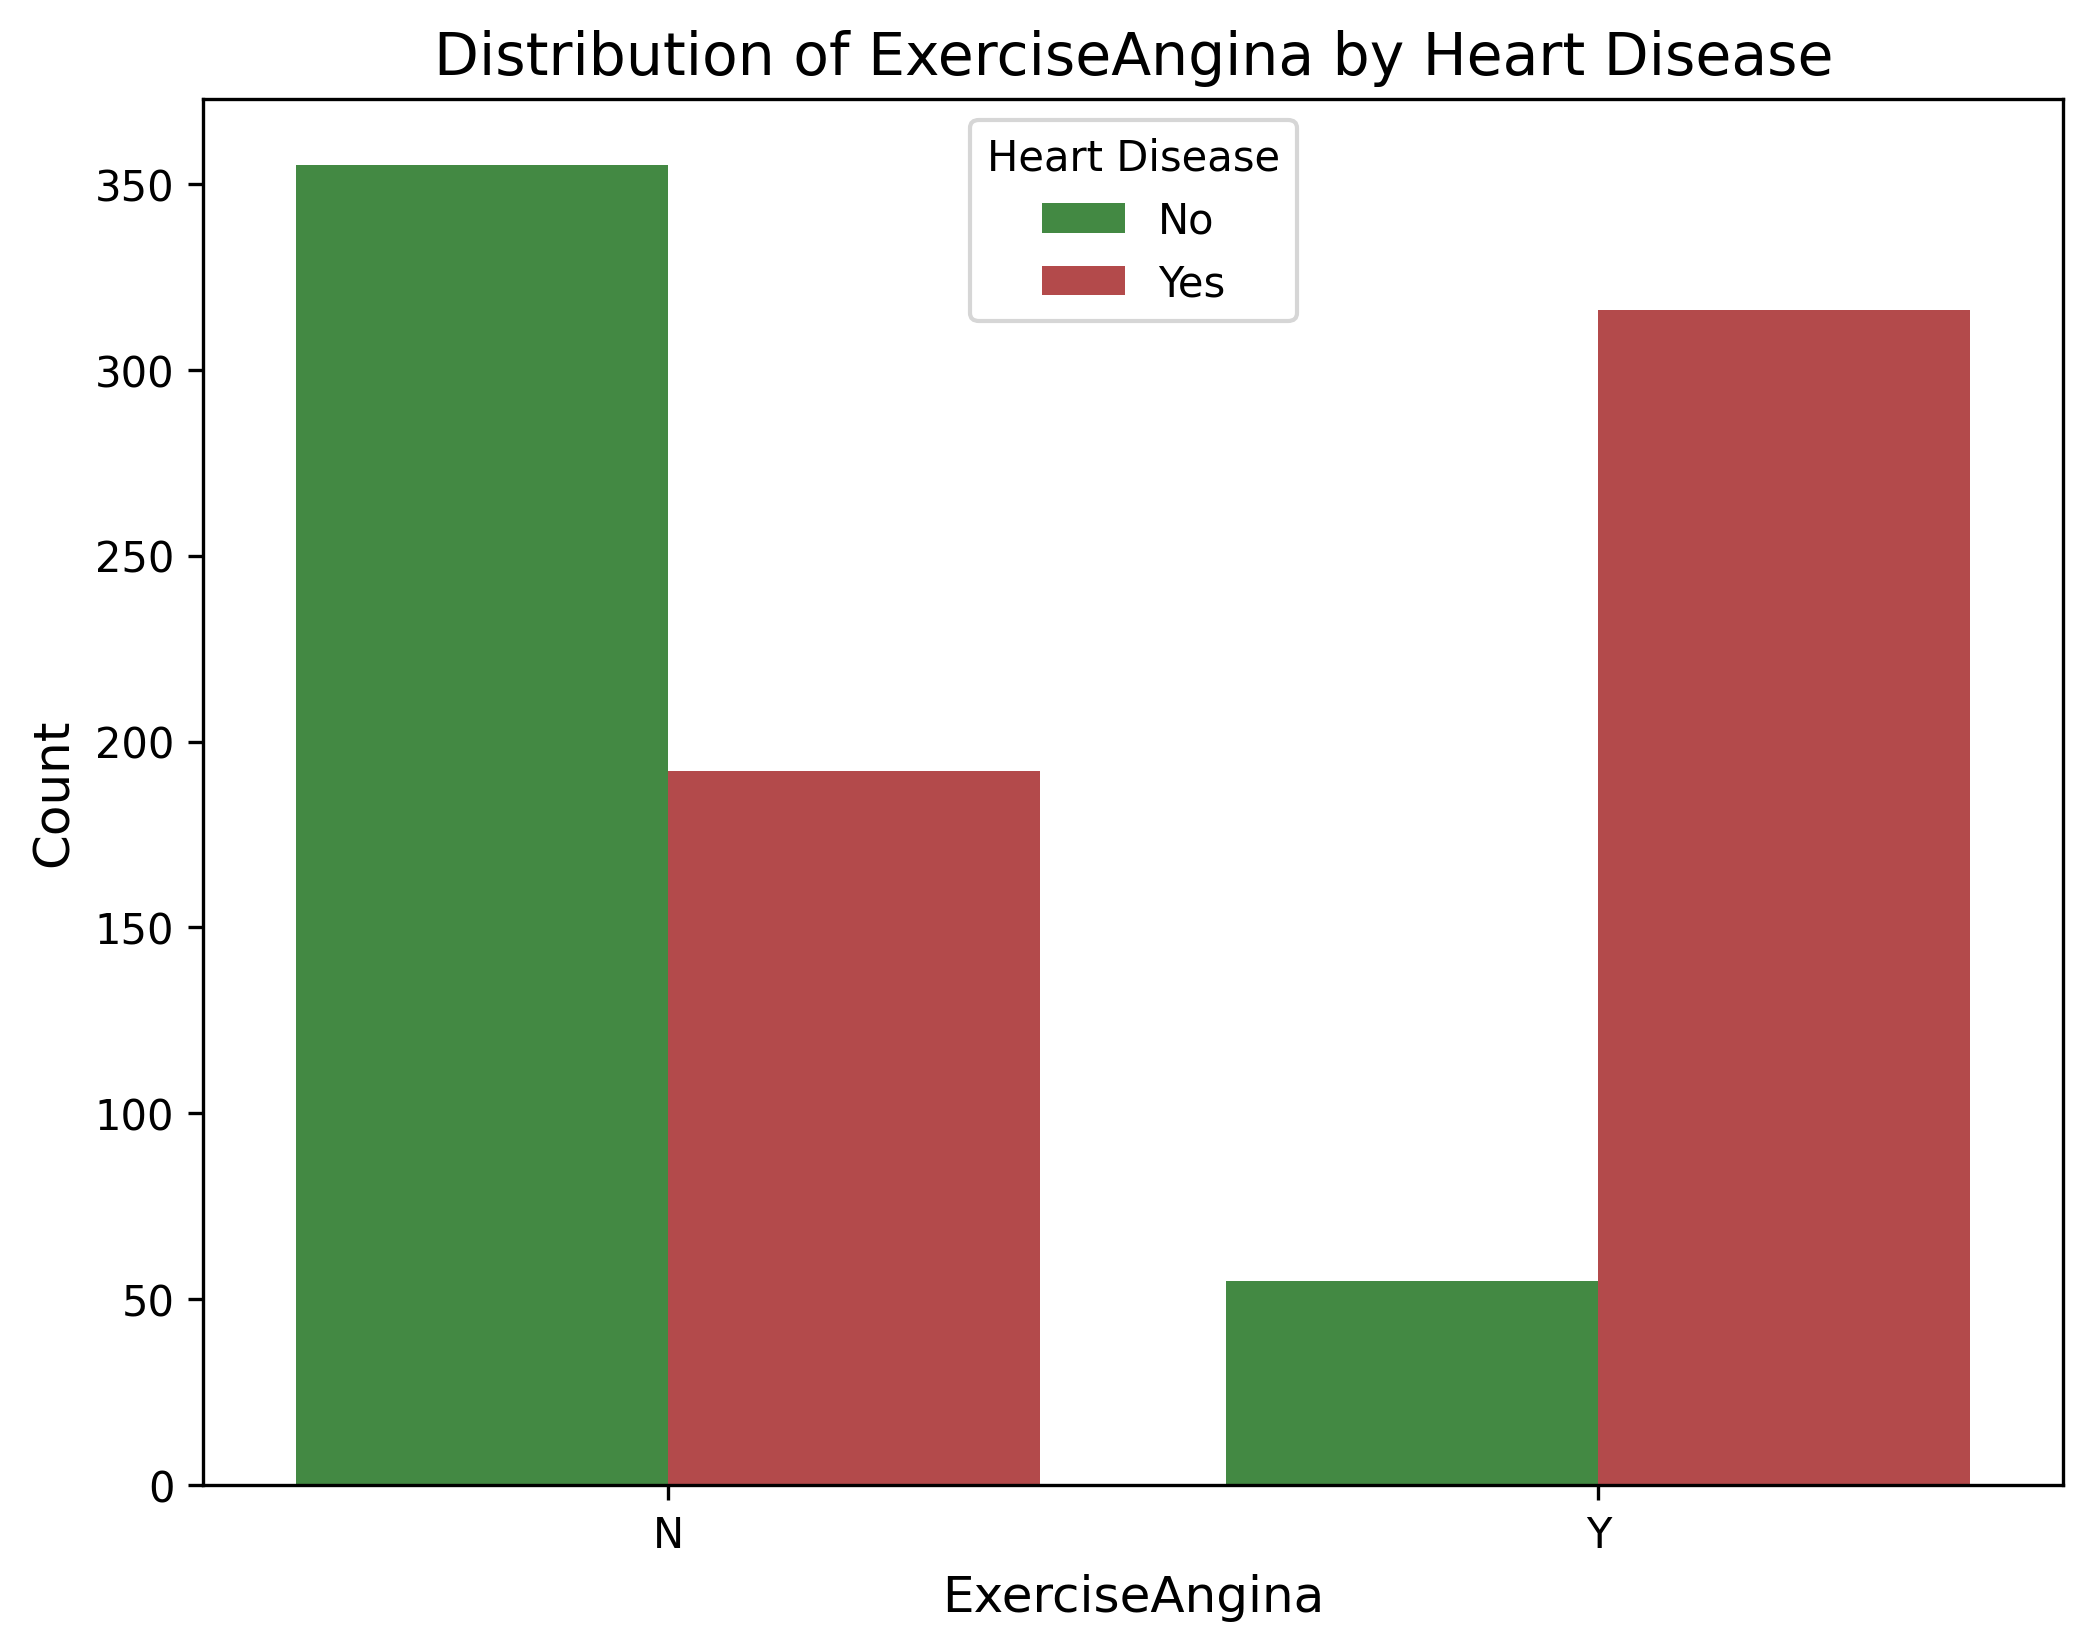

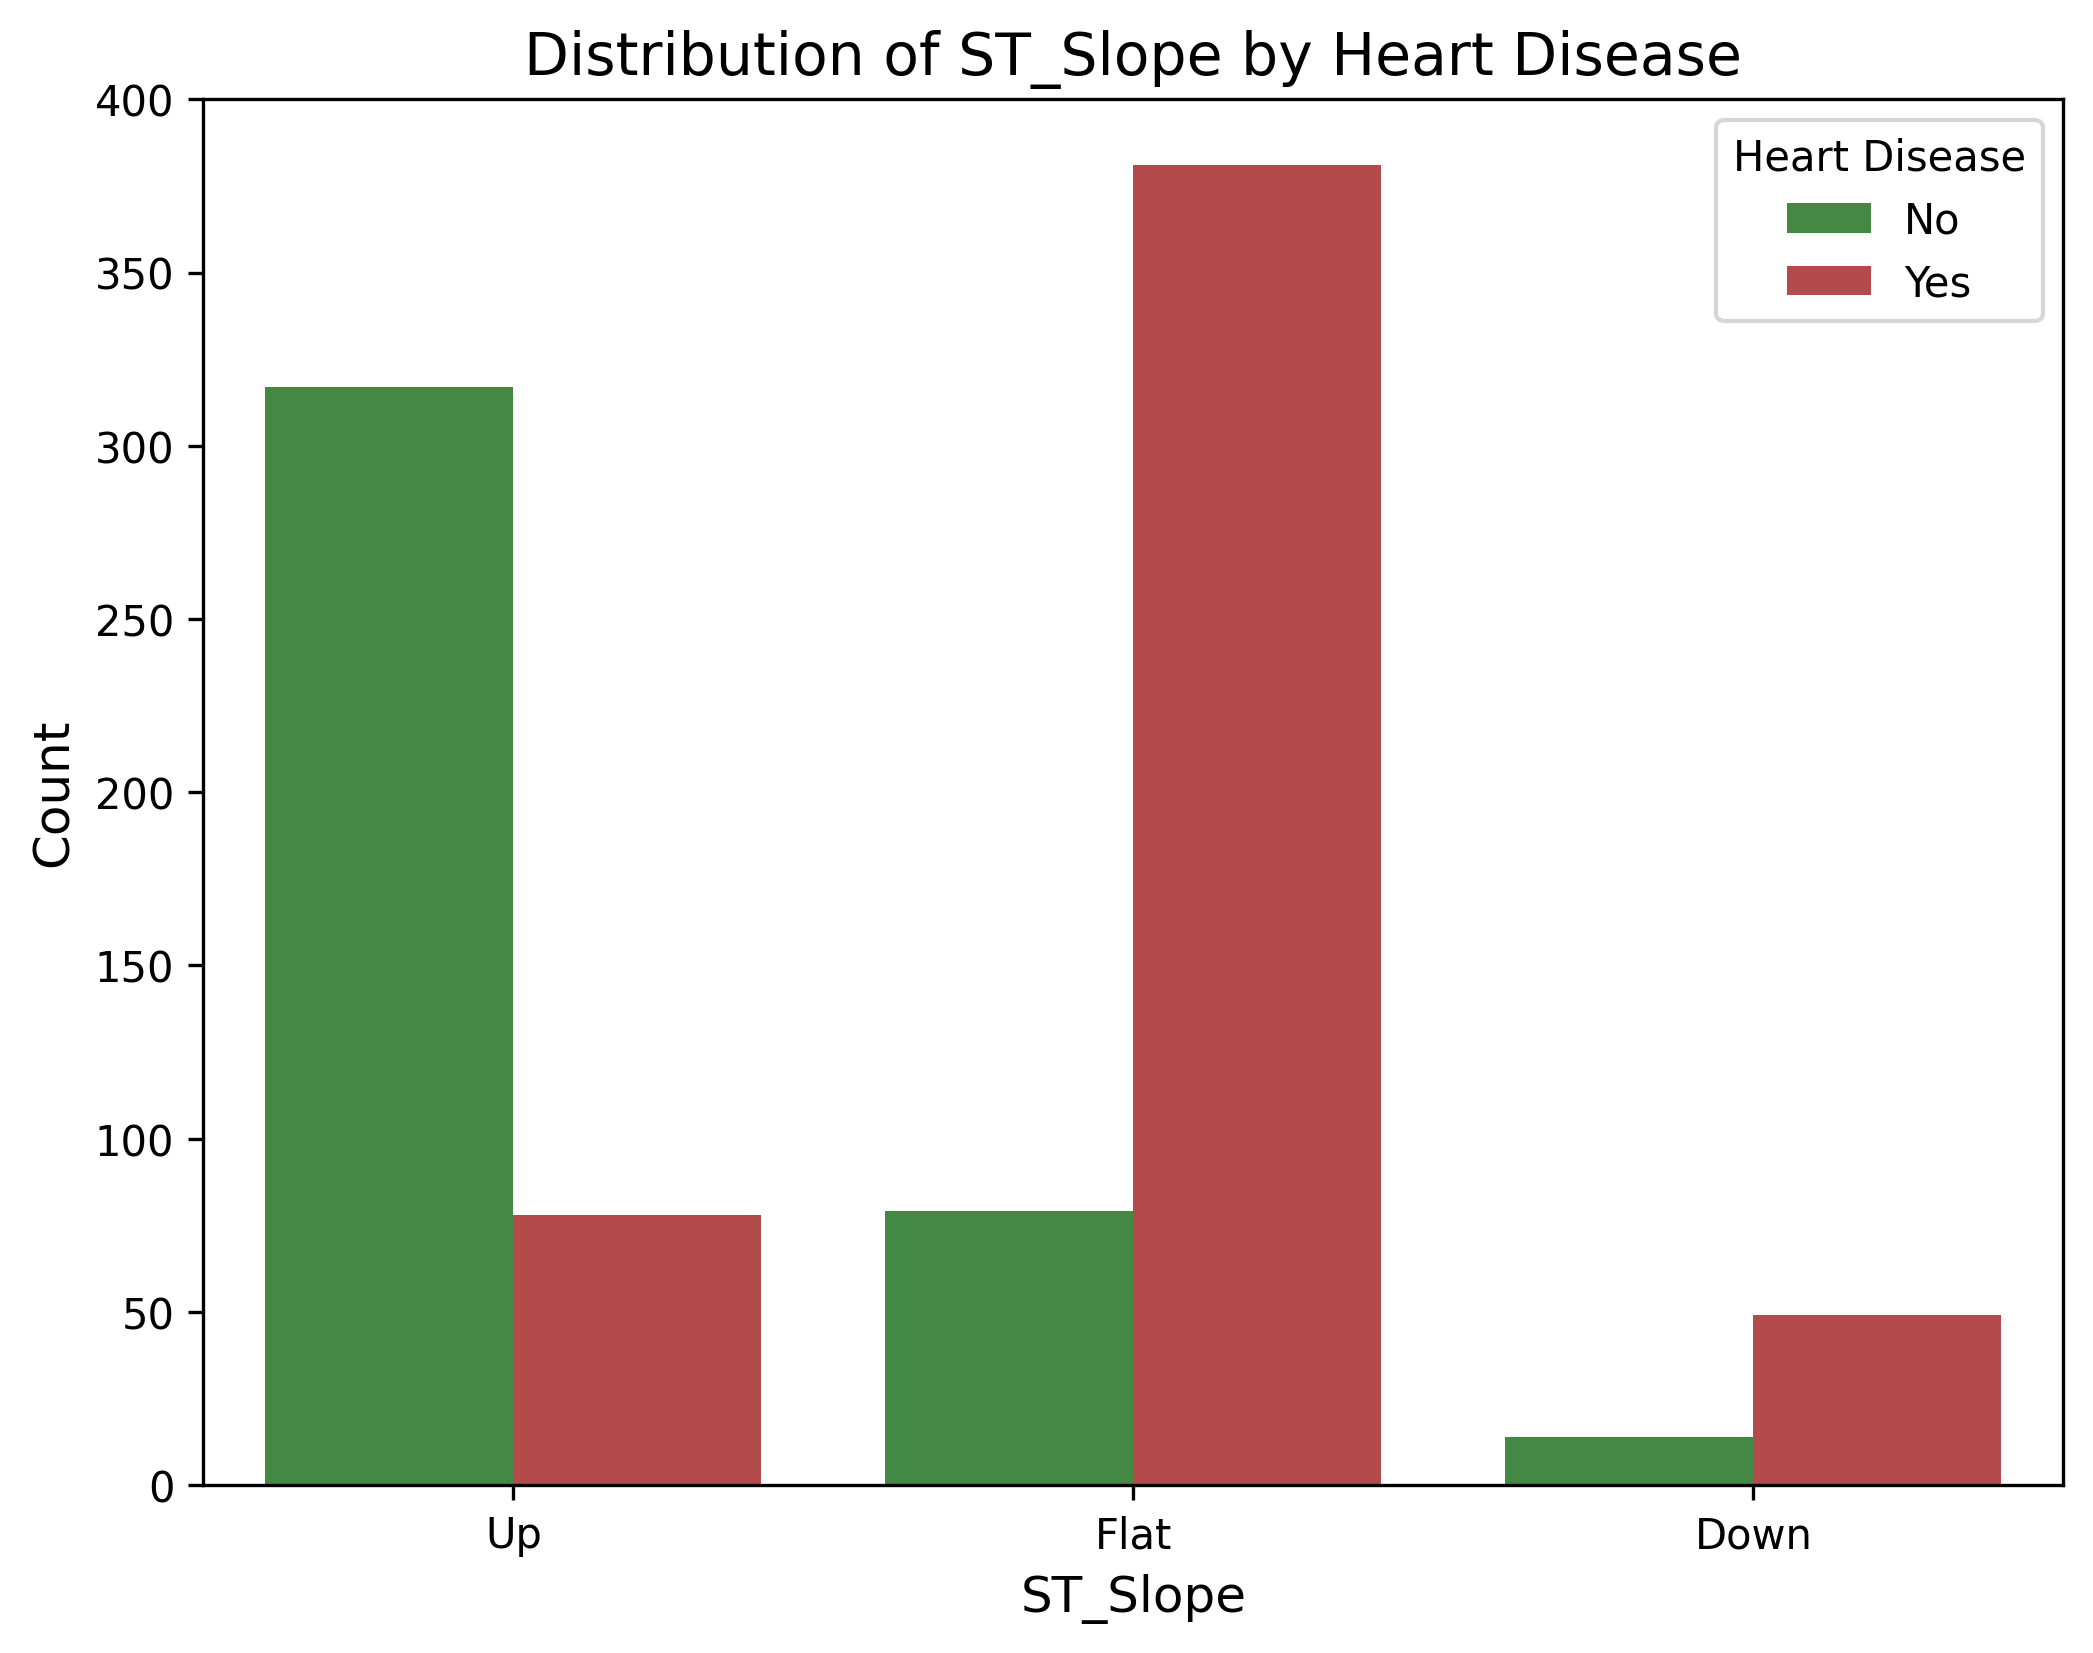

In [27]:

color_no_hd = "#2ca02c"  # Green (No Heart Disease)
color_hd = "#d62728"  # Red (Heart Disease)
palette = {0: color_no_hd, 1: color_hd}

cat_cols = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
# Loop through categorical features and plot
for col in cat_cols:
    plt.figure(figsize=(8, 6), dpi=300)
    
    # Countplot with manual colors
    sns.countplot(x=col, data=df, hue='HeartDisease', palette=palette, saturation=0.6)
    
    # Title and labels
    plt.title(f'Distribution of {col} by Heart Disease', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    
    # Update legend for clarity
    plt.legend(title="Heart Disease", labels=["No", "Yes"])

    # Show plot
    plt.show()


# Box Plots

/var/folders/hy/g3t8vhw56m794ysxc7bw8vrh0000gn/T/ipykernel_44124/3501541389.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['HeartDisease'] = df['HeartDisease'].astype(str).replace({"0": "No Heart Disease", "1": "Heart Disease"})


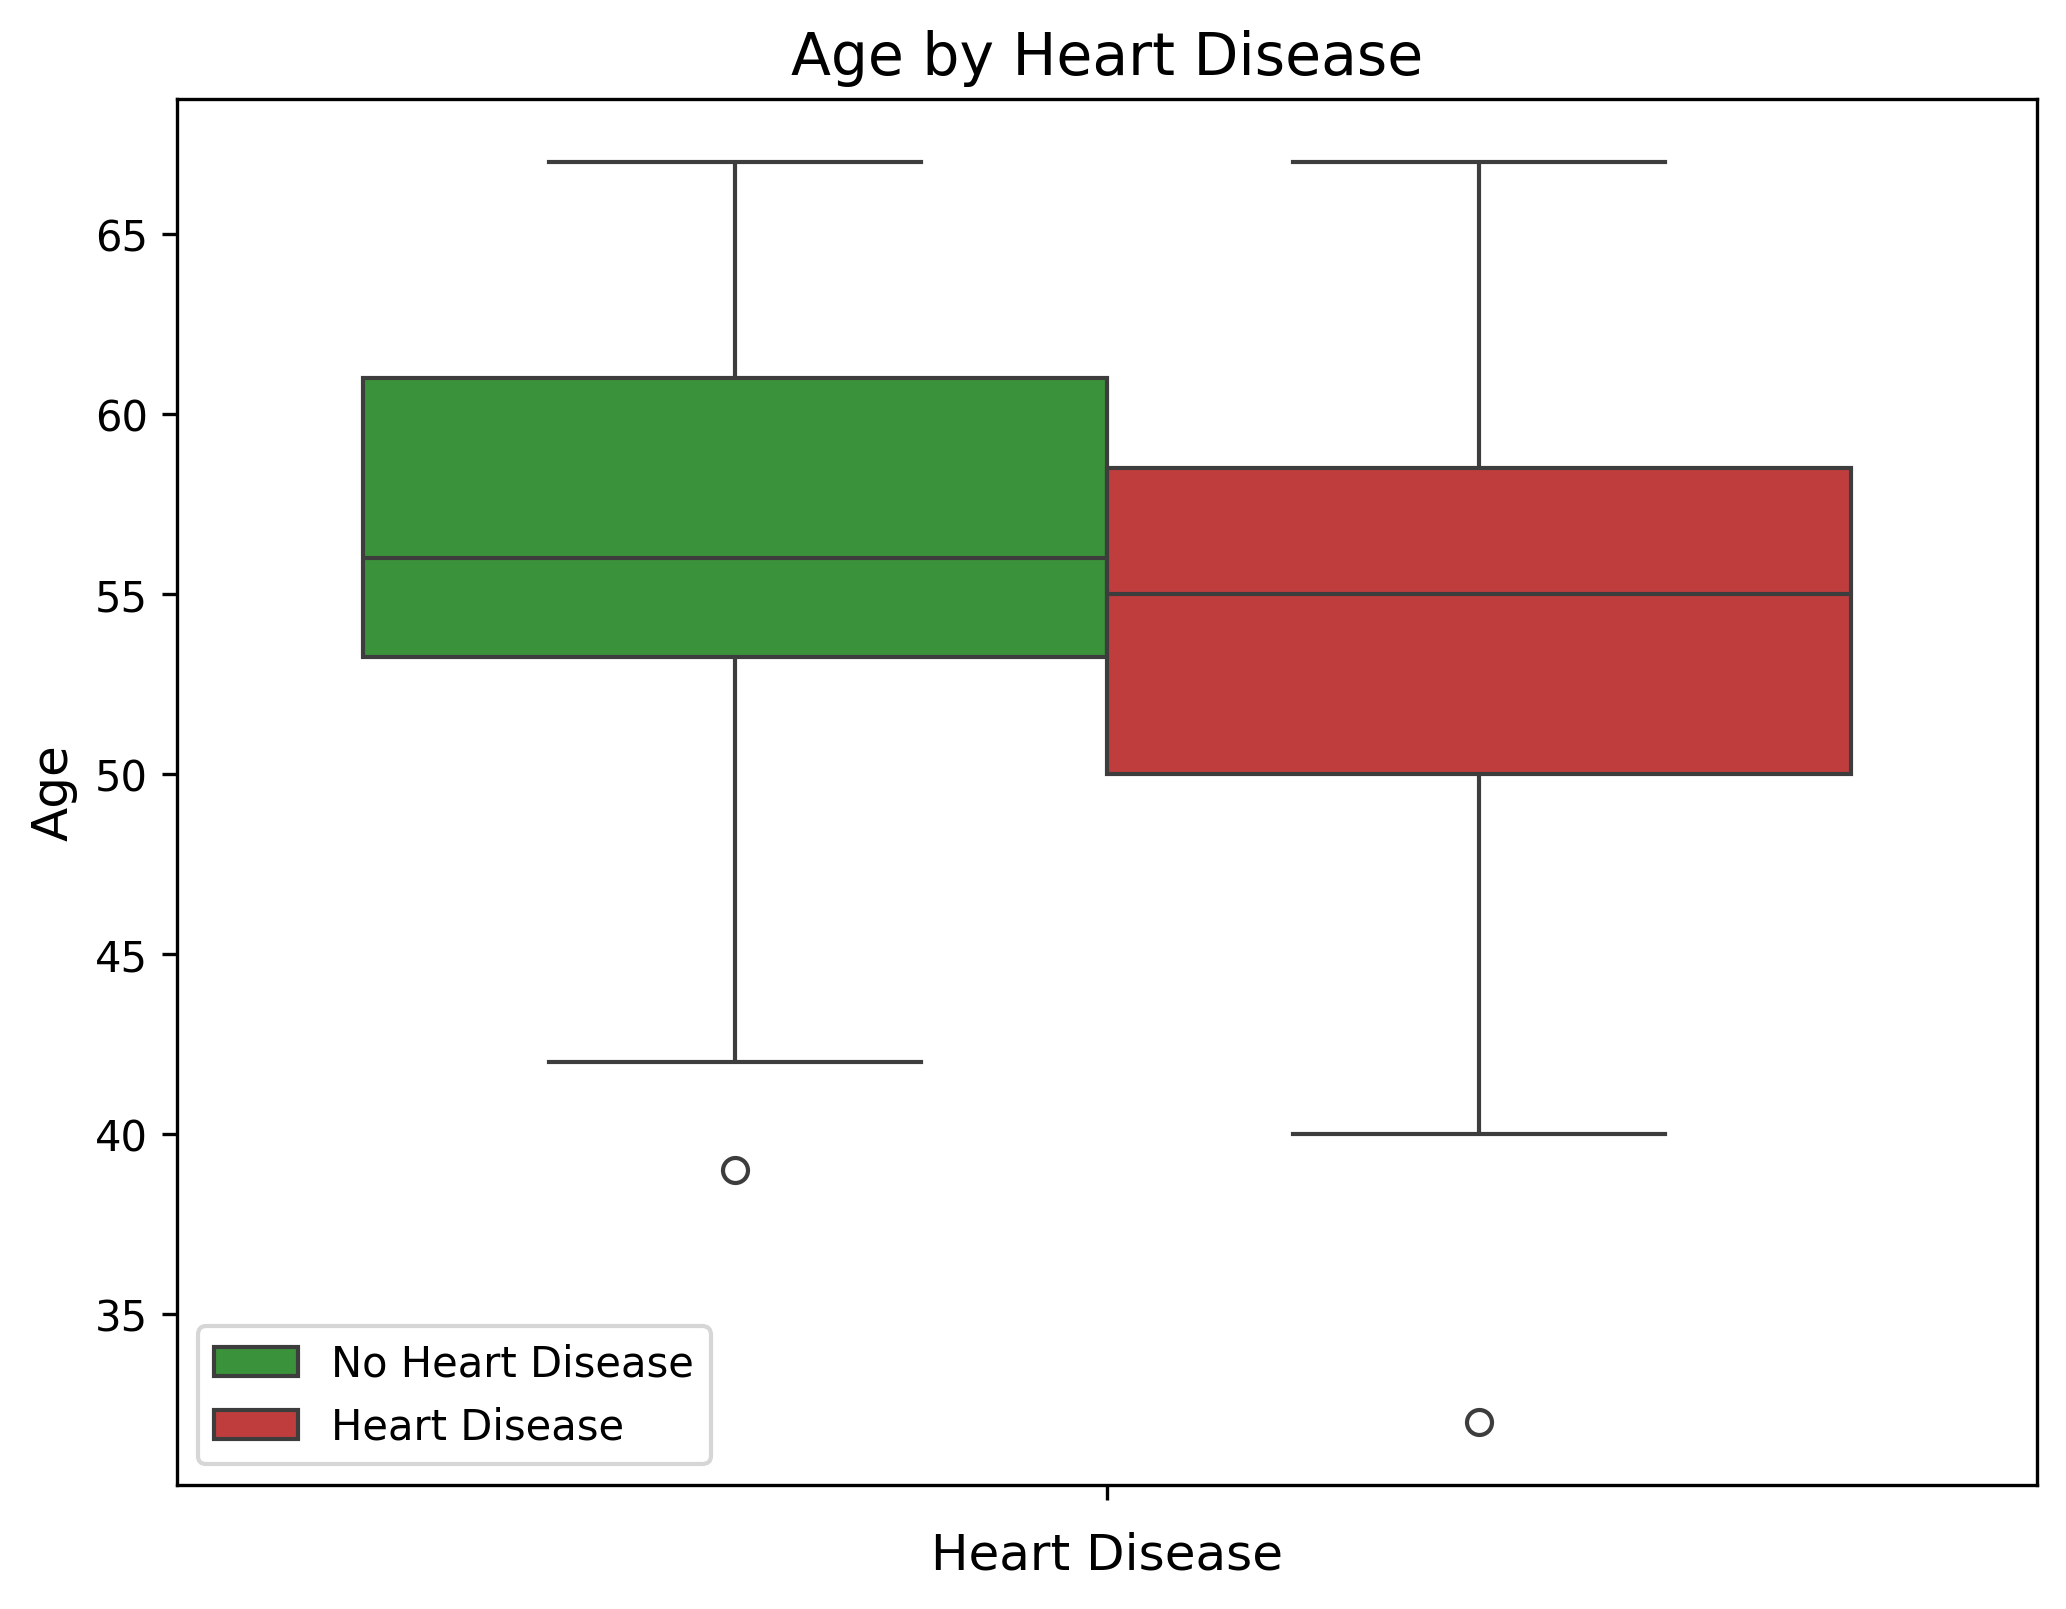

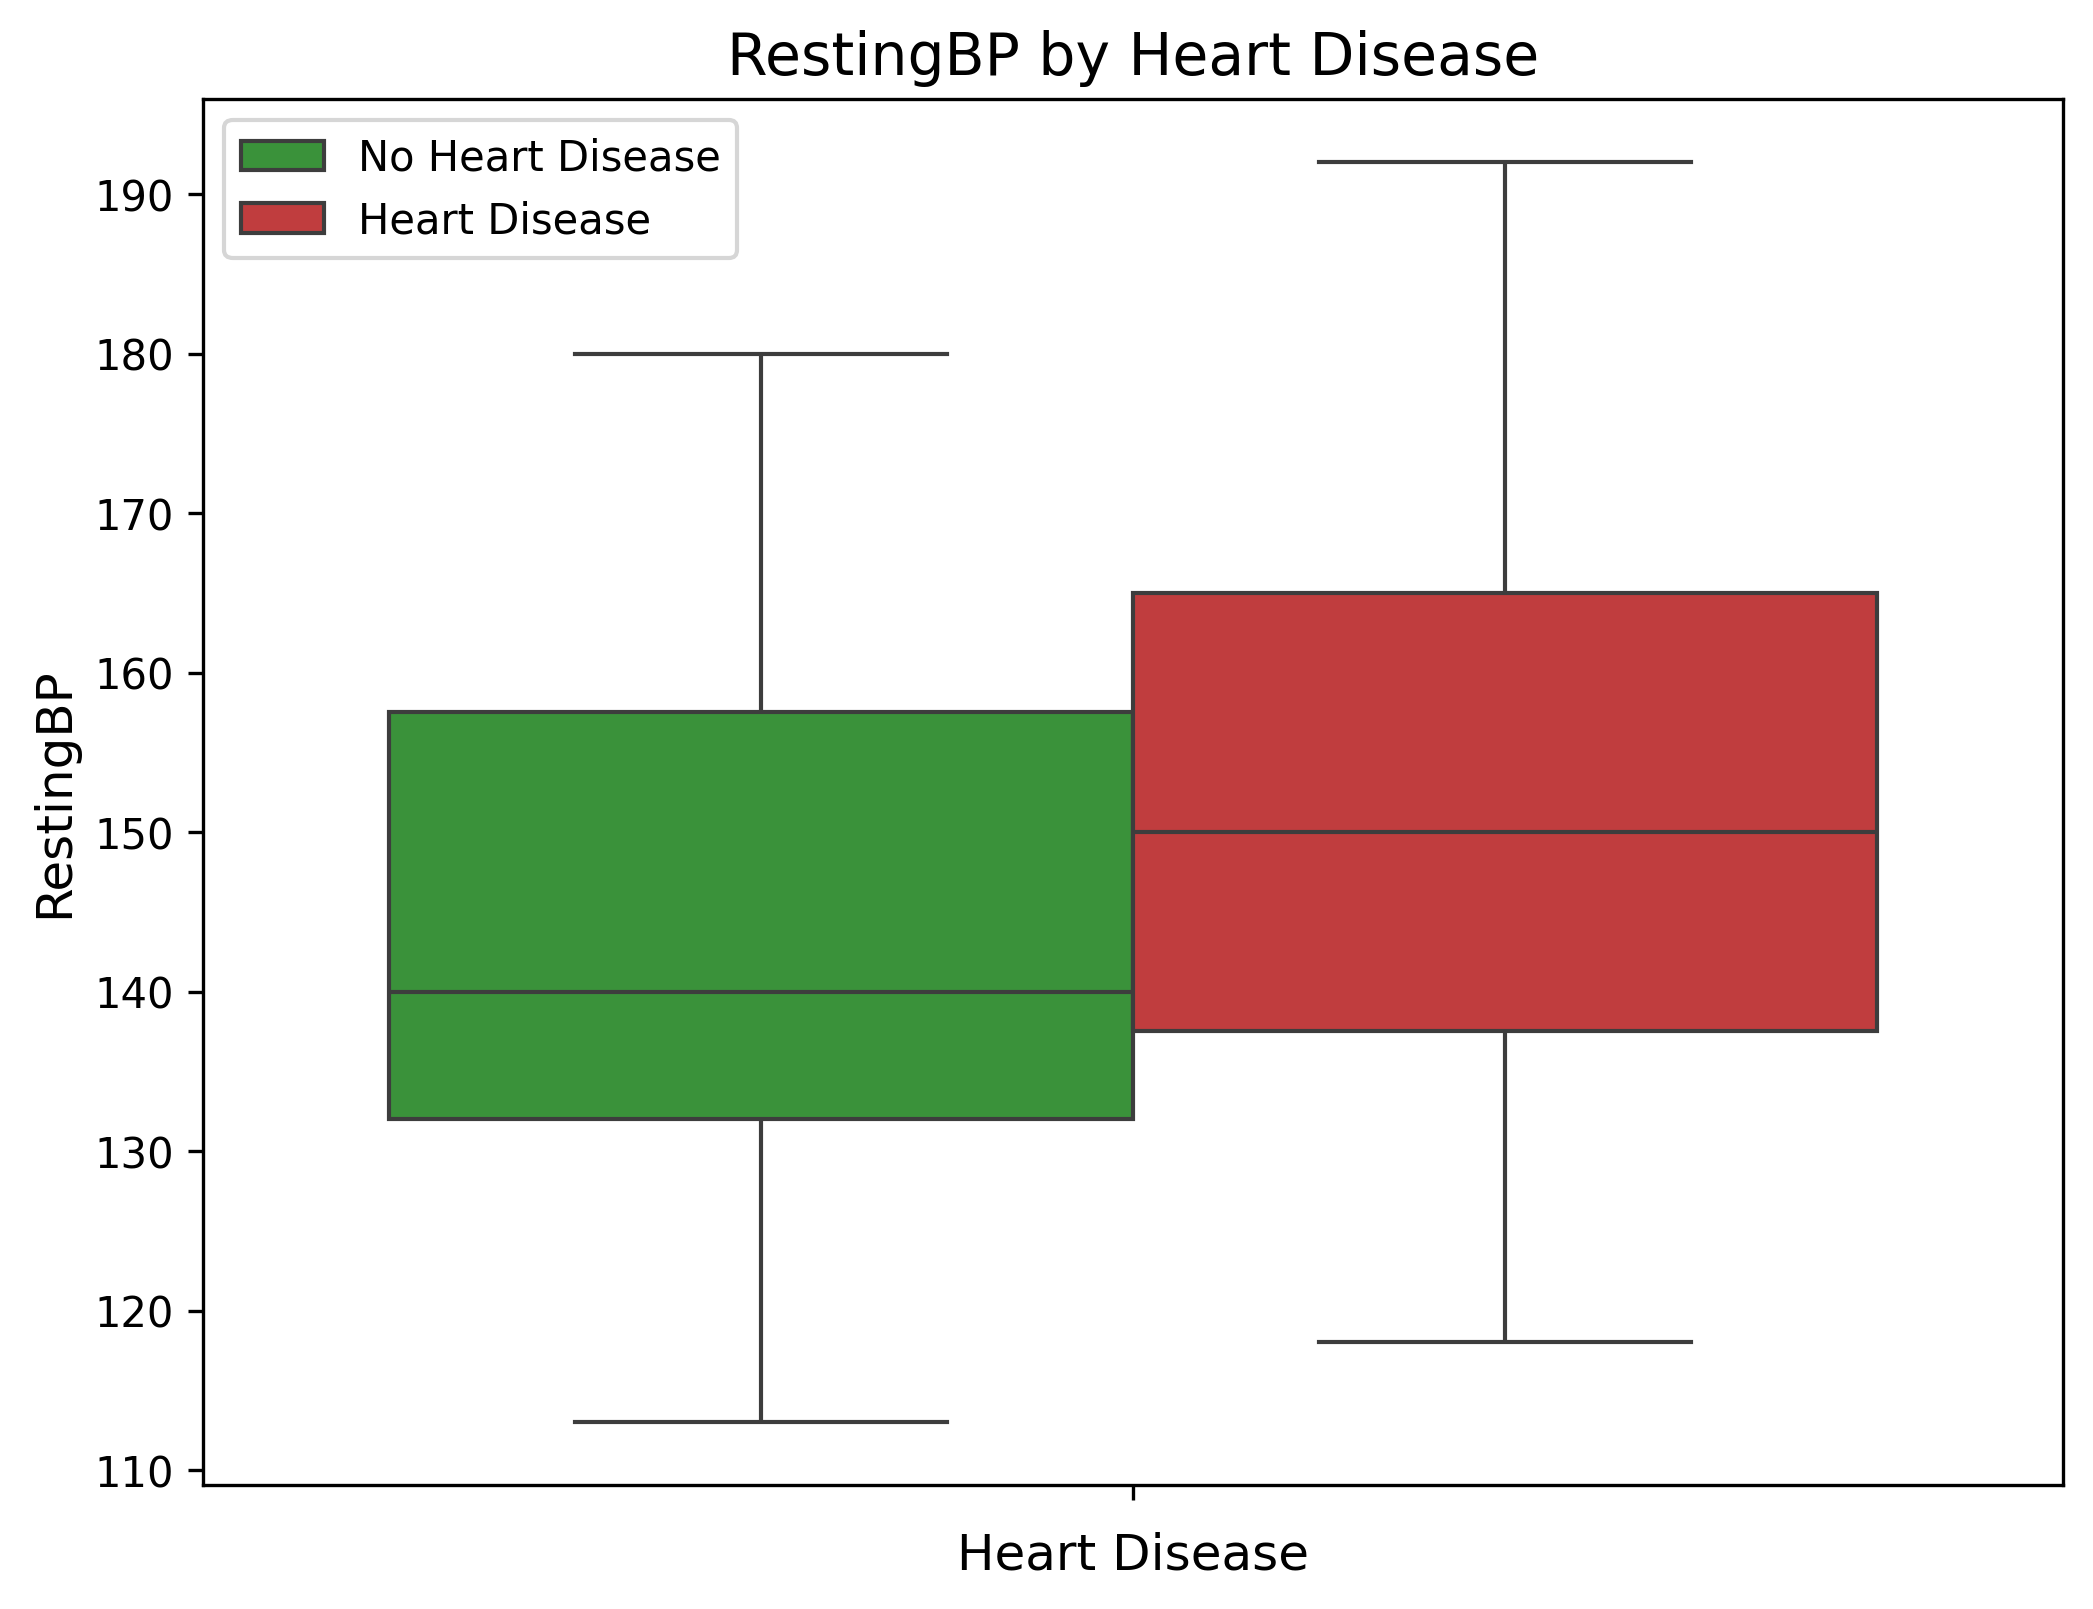

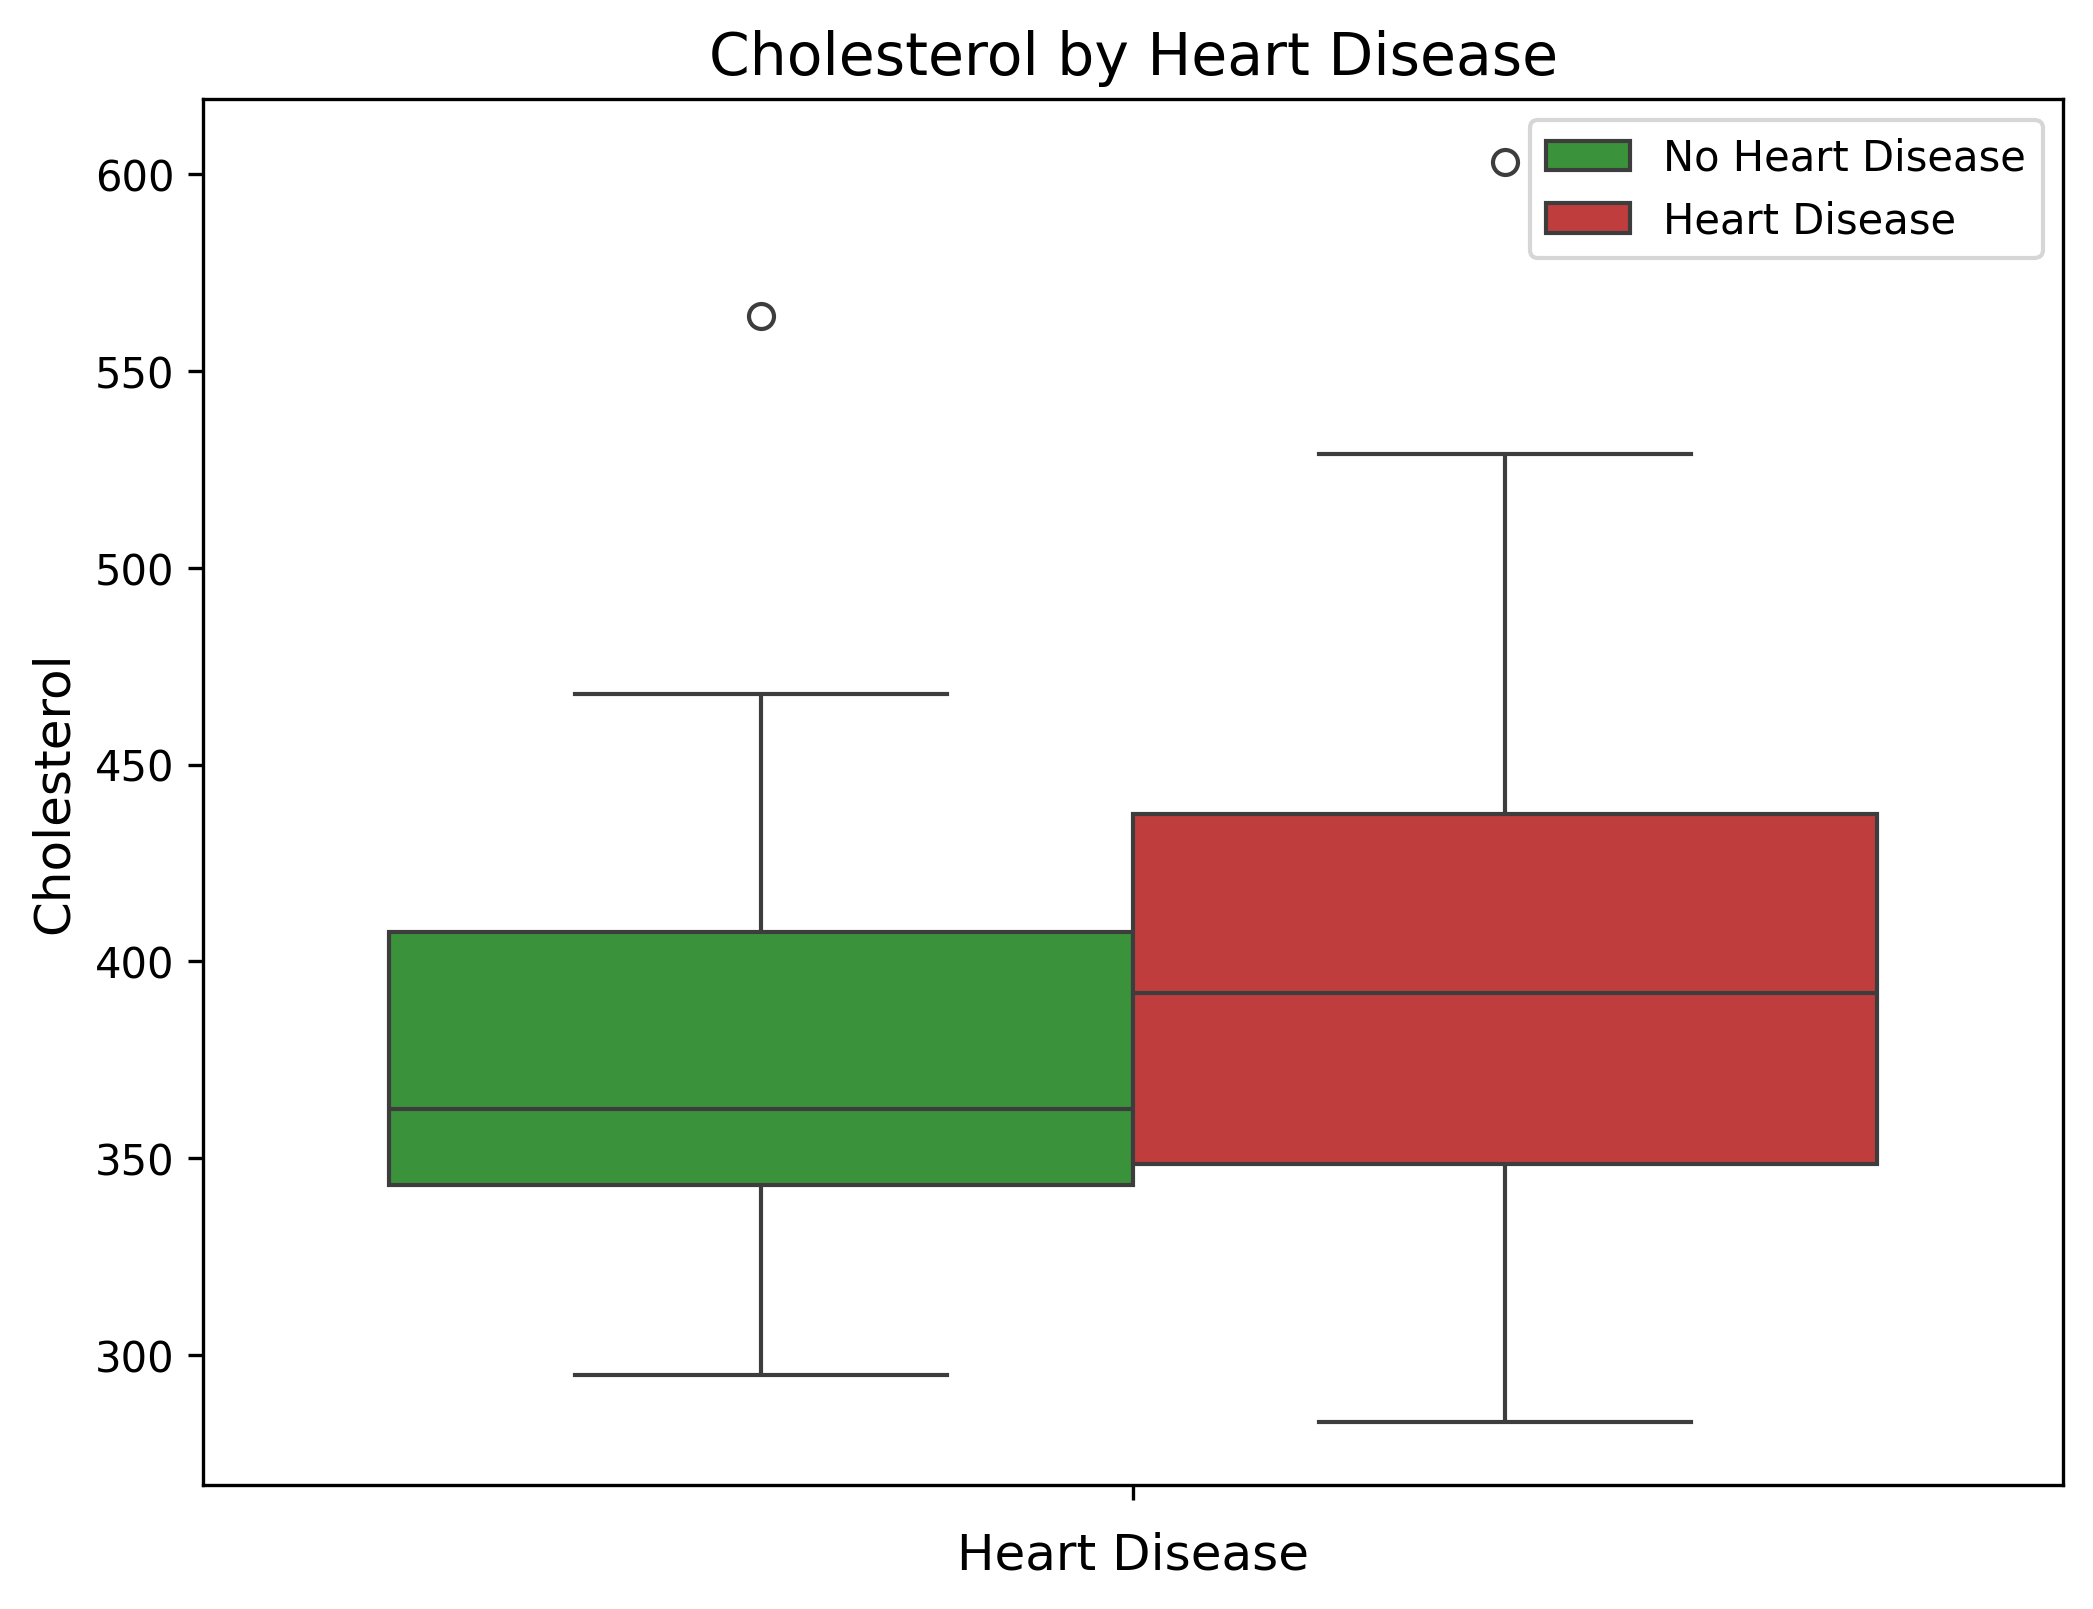

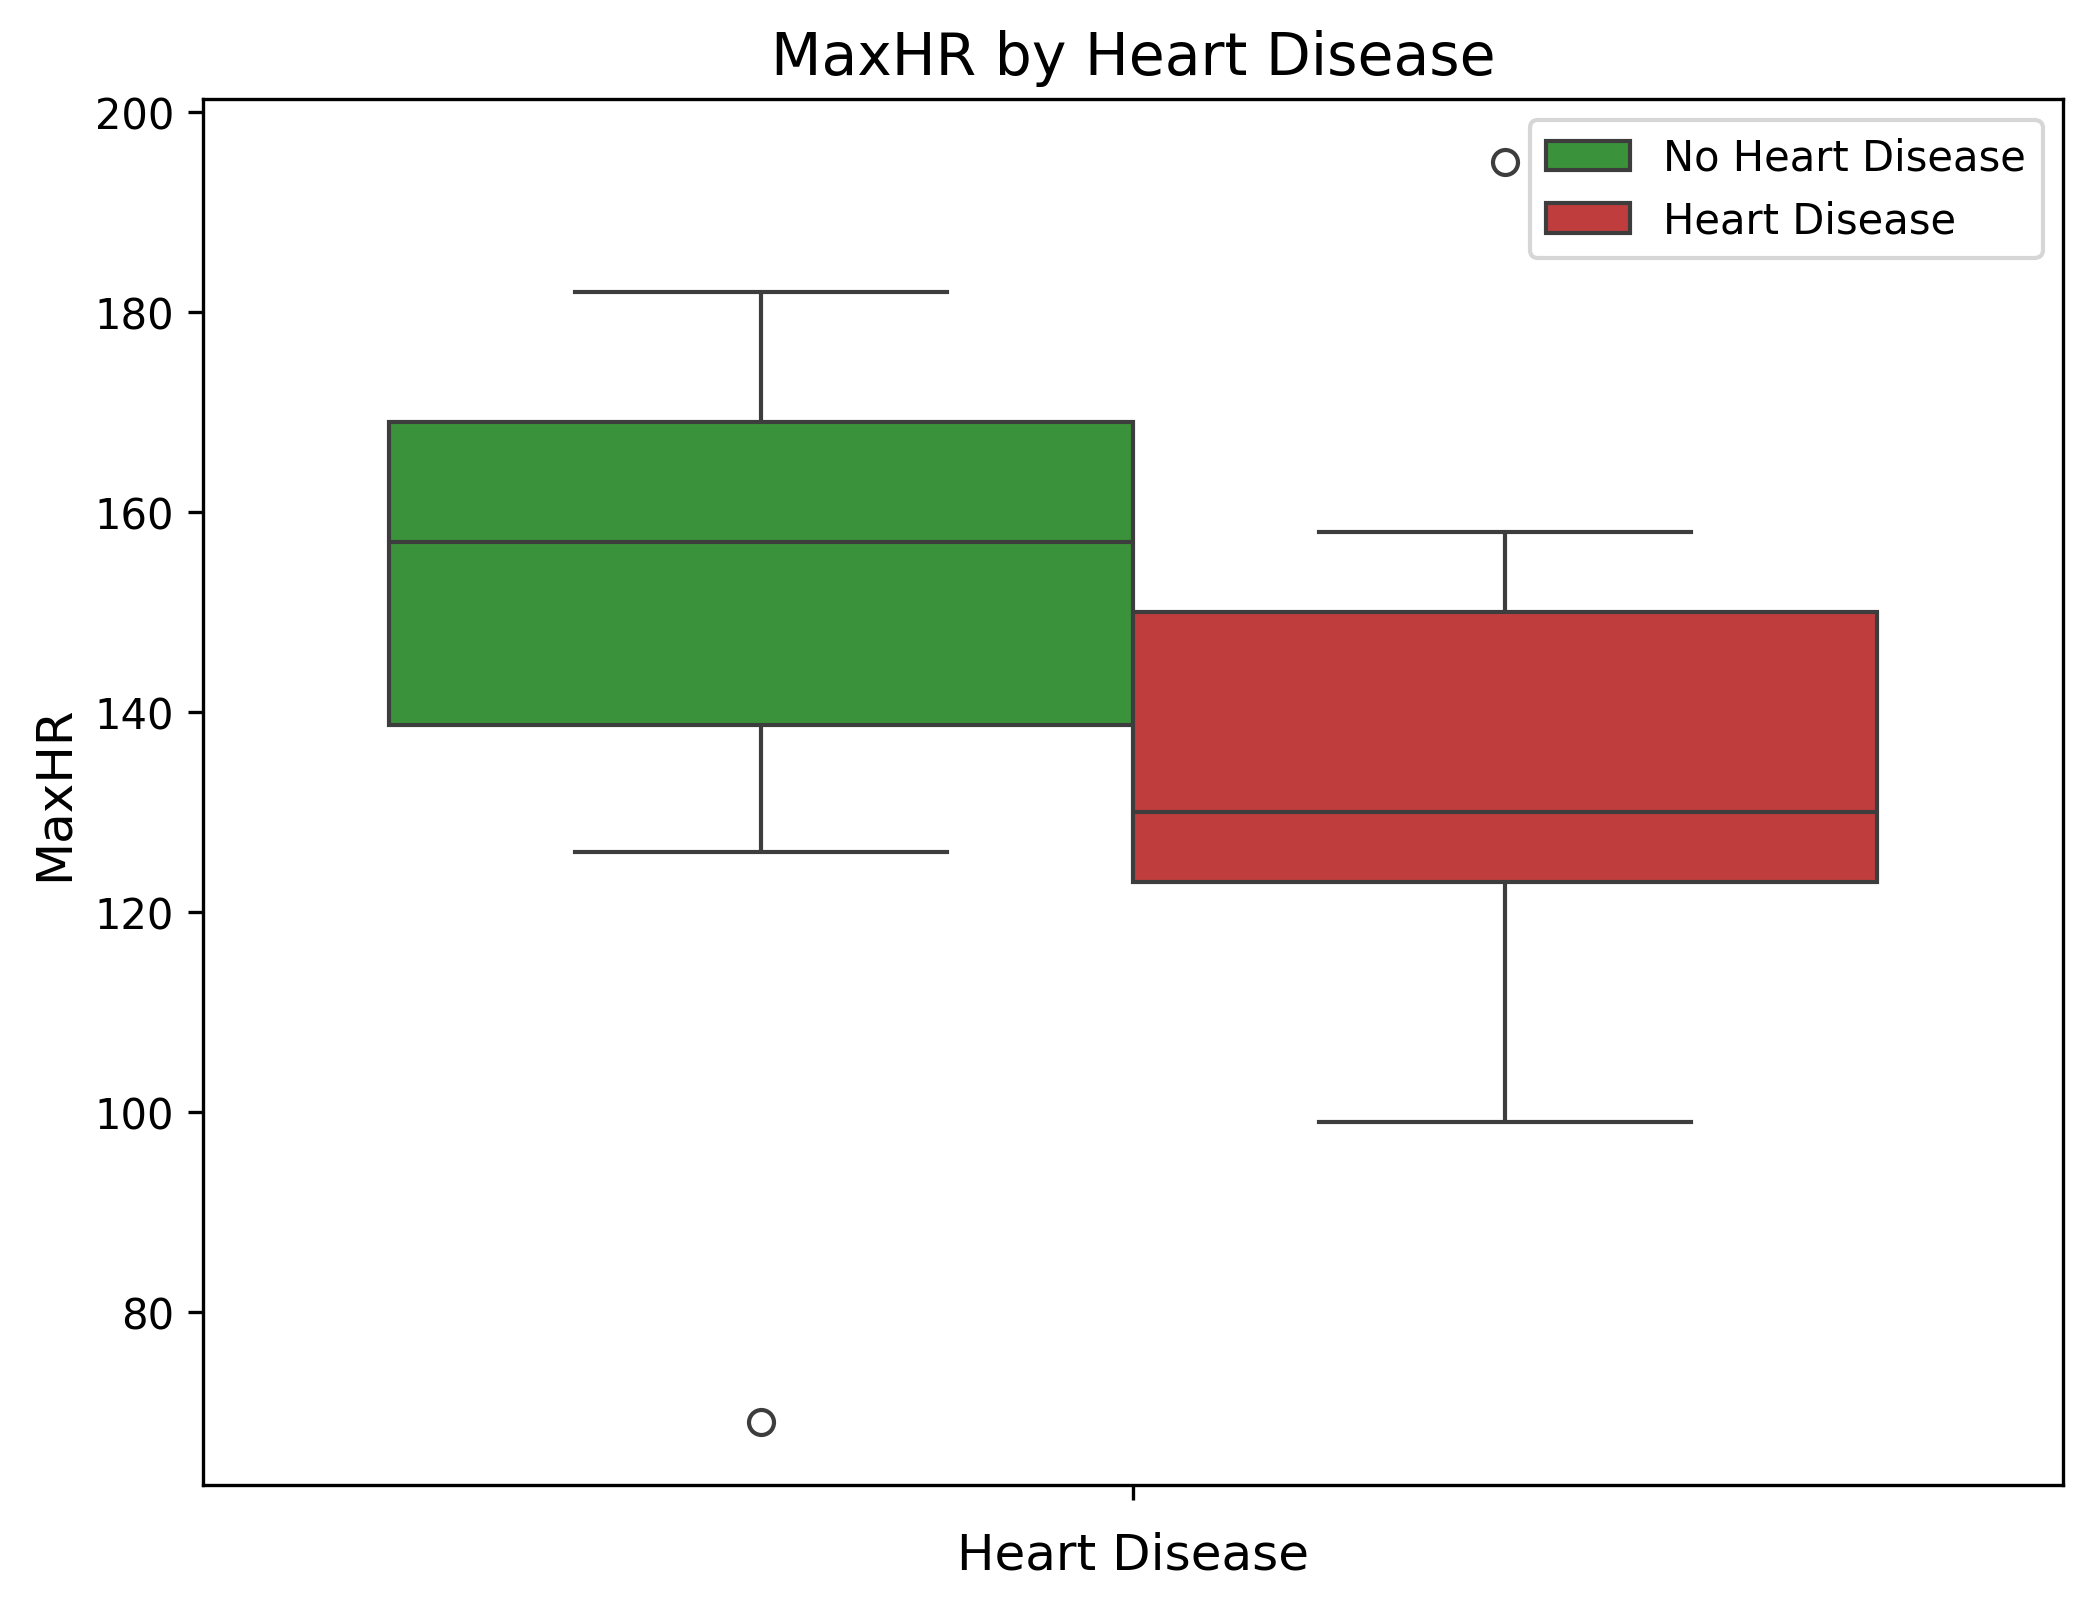

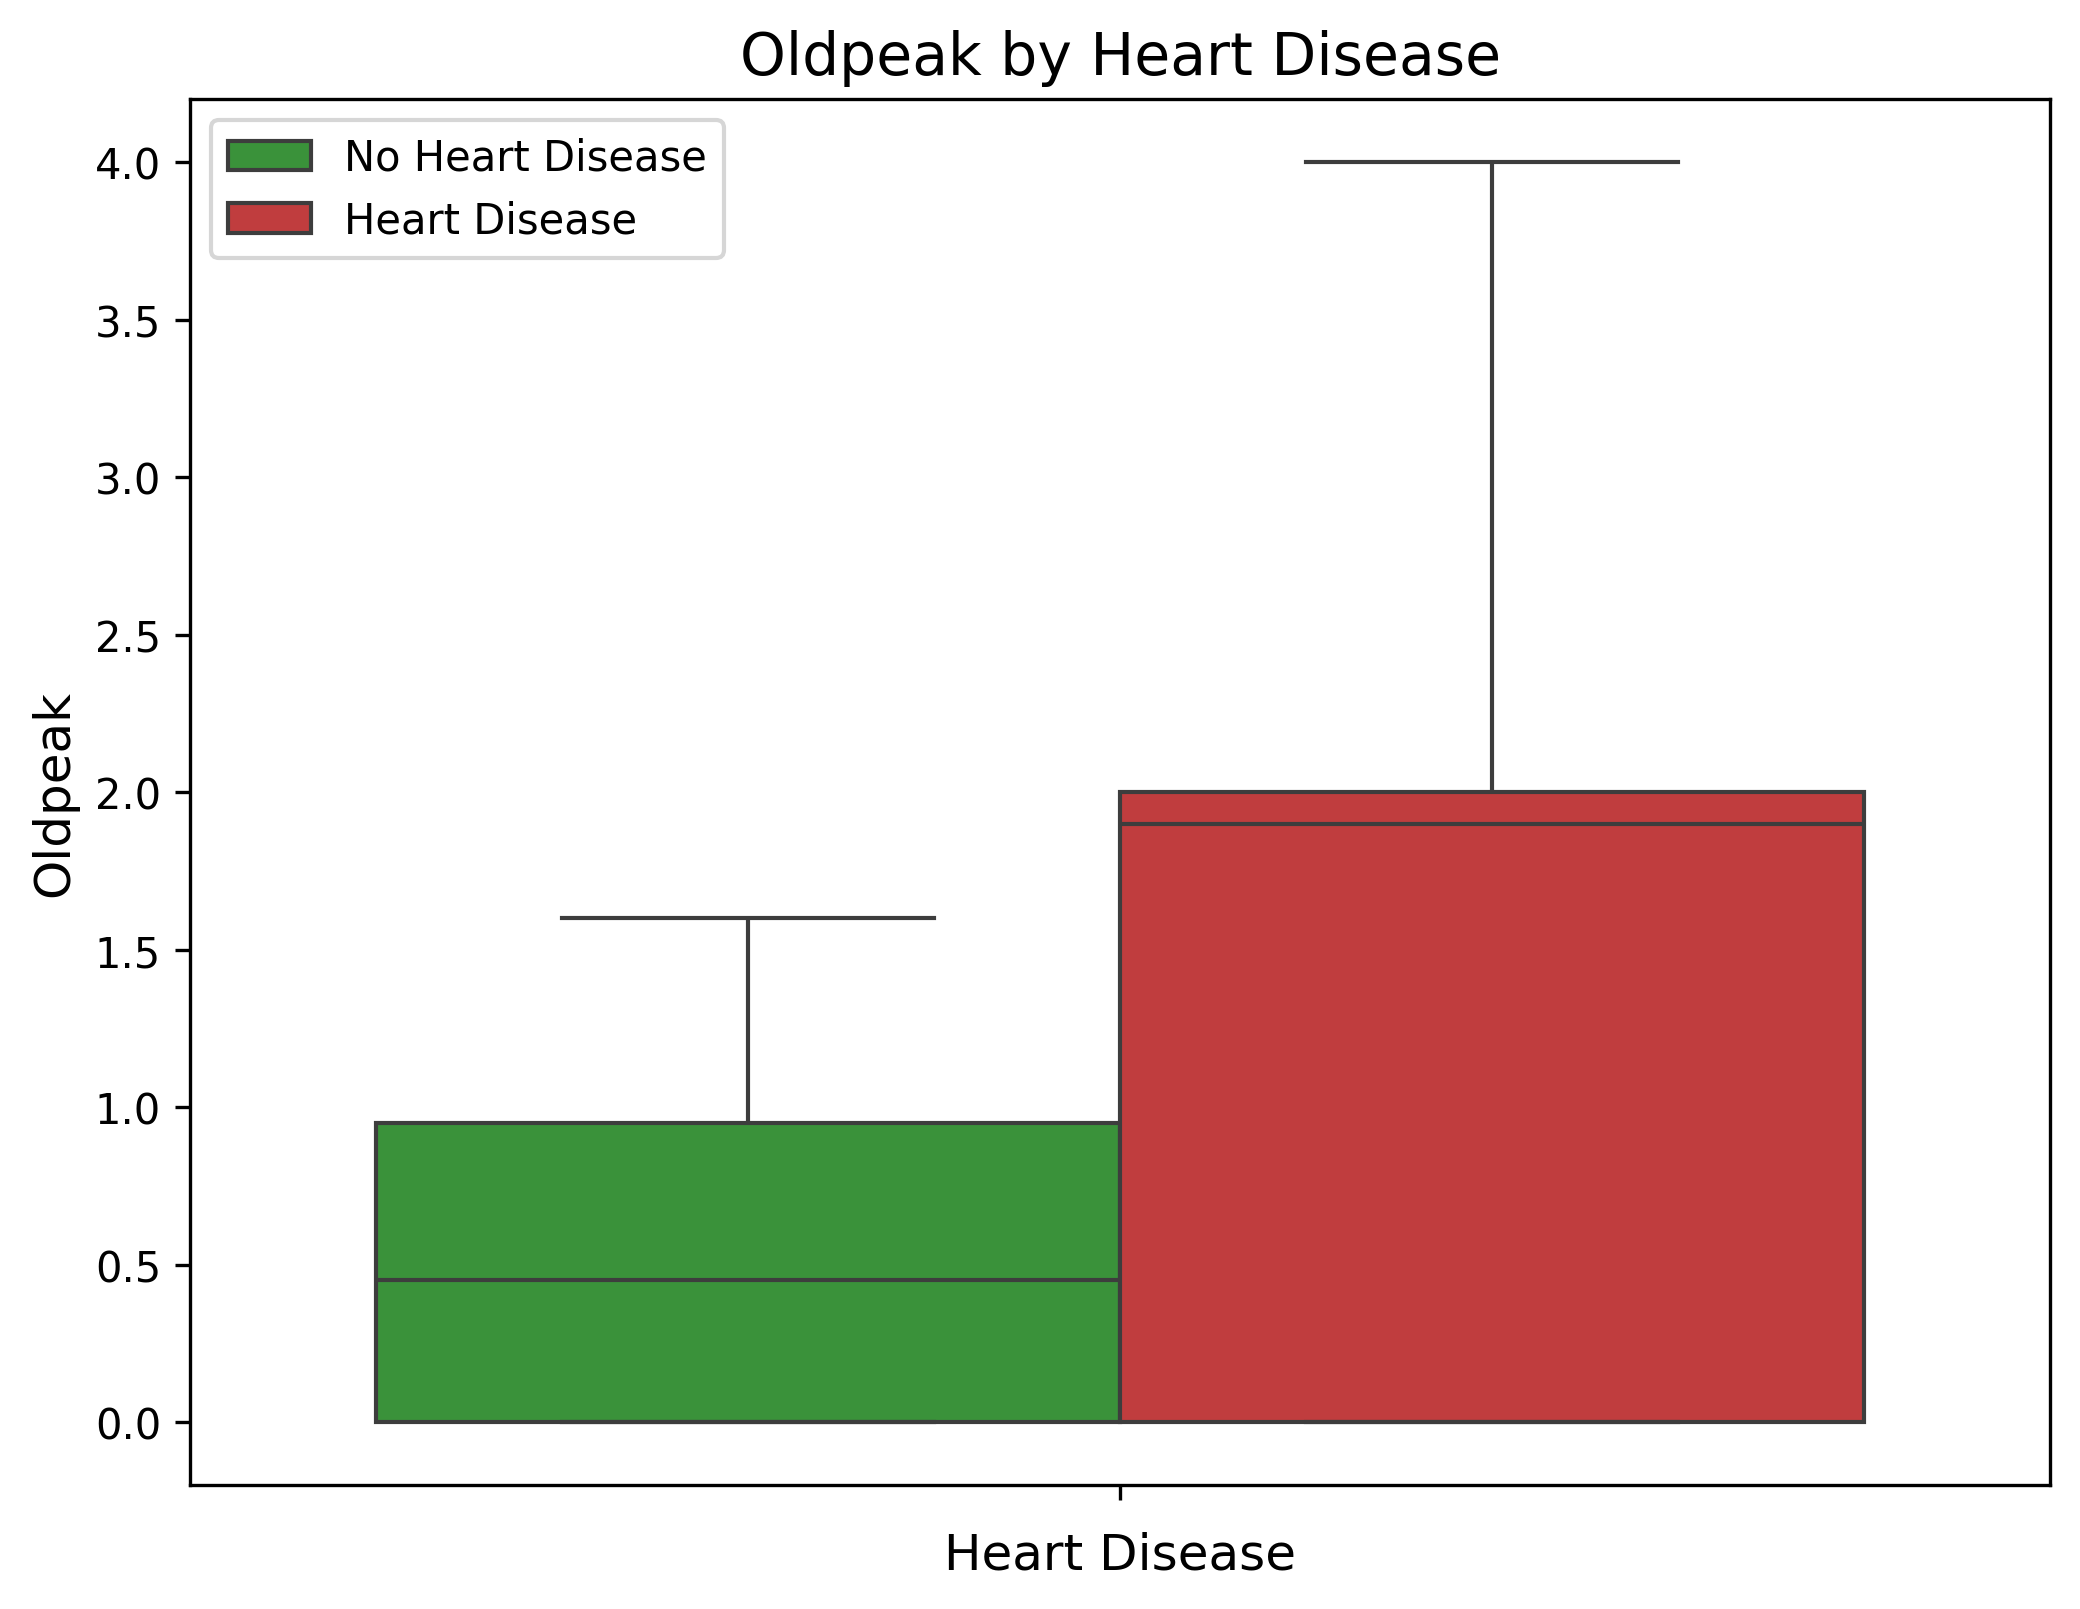

In [47]:

# Ensure HeartDisease is categorical with proper labeling
df['HeartDisease'] = df['HeartDisease'].astype(str).replace({"0": "No Heart Disease", "1": "Heart Disease"})

# Define colors with proper labels
palette = {"No Heart Disease": "#2ca02c", "Heart Disease": "#d62728"}  # Green = No HD, Red = HD

# Numerical columns
num_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

# Loop through numerical features and plot boxplots
for col in num_cols:
    plt.figure(figsize=(8, 6), dpi=300)
    
    sns.boxplot(y=col, data=df, palette=palette, hue='HeartDisease')
    
    plt.title(f'{col} by Heart Disease', fontsize=14)
    plt.xlabel("Heart Disease", fontsize=12)
    plt.ylabel(col, fontsize=12)
    
    # Update legend title for clarity
    plt.legend()

    plt.show()
